In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


In [2]:
plt.rcParams.update({'font.size': 12})

In [4]:
df = pd.read_csv('../data/day_approach_maskedID_timeseries.csv')
df = df[df['Athlete ID'] != 5]
df.head()

nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
0           1.0       5.8      0.0          0.6           1.2   
1           0.0       0.0      0.0          0.0           0.0   
2           1.0       0.0      0.0          0.0           0.0   
3           0.0       0.0      0.0          0.0           0.0   
4           1.0       0.0      0.0          0.0           0.0   

   strength training  hours alternative  perceived exertion  \
0                0.0               0.00                0.11   
1                0.0               0.00               -0.01   
2                1.0               0.00                0.10   
3                0.0               0.00               -0.01   
4                0.0               1.08                0.08   

   perceived trainingSuccess  perceived recovery  ...  km Z5-T1-T2.6  \
0                       0.00                0.18  ...            0.0   
1                      -0.01               -0.01  ...            0.5   
2                       0.00                0.17  ...            0.0   
3                      -0.01               -0.01  ...            0.0   
4                       0.00                0.18  ...            0.0   

   km sprinting.6  strength training.6  hours alternative.6  \
0             0.0                  0.0                  1.0   
1             1.2                  0.0                  0.0   
2             0.0                  0.0                  0.0   
3             0.0                  1.0                  0.0   
4             0.0                  0.0                  0.0   

   perceived exertion.6  perceived trainingSuccess.6  perceived recovery.6  \
0                  0.10                         0.00                  0.15   
1                  0.10                         0.00                  0.17   
2                 -0.01                        -0.01                 -0.01   
3                  0.10                         0.00                  0.17   
4                  0.11                         0.00                  0.17   

   Athlete ID  injury  Date  
0           0       0     0  
1           0       0     1  
2           0       0     2  
3           0       0     3  
4           0       0     4  

[5 rows x 73 columns]

## Choosing an athlete to predict: ##

for my first model, I choose the athlete that has the higher percentage of injury because a) this makes the dataset slightly less imbalanced b) it makes sense to predict for these athletes because we want to reduce injury for those that are mostly likely to get injured

In [4]:
# how likely does each athlete get injured?
perc_injured_per_athlete = df.groupby(['Athlete ID']).agg({'injury':'sum','Date':'count'}).reset_index()
perc_injured_per_athlete['perc_injury'] = perc_injured_per_athlete['injury'] / df.groupby(['Athlete ID']).agg({'injury':'count'})['injury']
perc_injured_per_athlete = perc_injured_per_athlete.sort_values(by = ['perc_injury'])
perc_injured_per_athlete

Athlete ID  injury  Date  perc_injury
73          73       0   192     0.000000
62          62       0   196     0.000000
46          46       0   272     0.000000
72          72       0   216     0.000000
31          31       0   231     0.000000
..         ...     ...   ...          ...
68          68       8   235     0.034043
36          36      22   638     0.034483
26          26      35   884     0.039593
42          42      32   744     0.043011
29          29      33   730     0.045205

[74 rows x 4 columns]

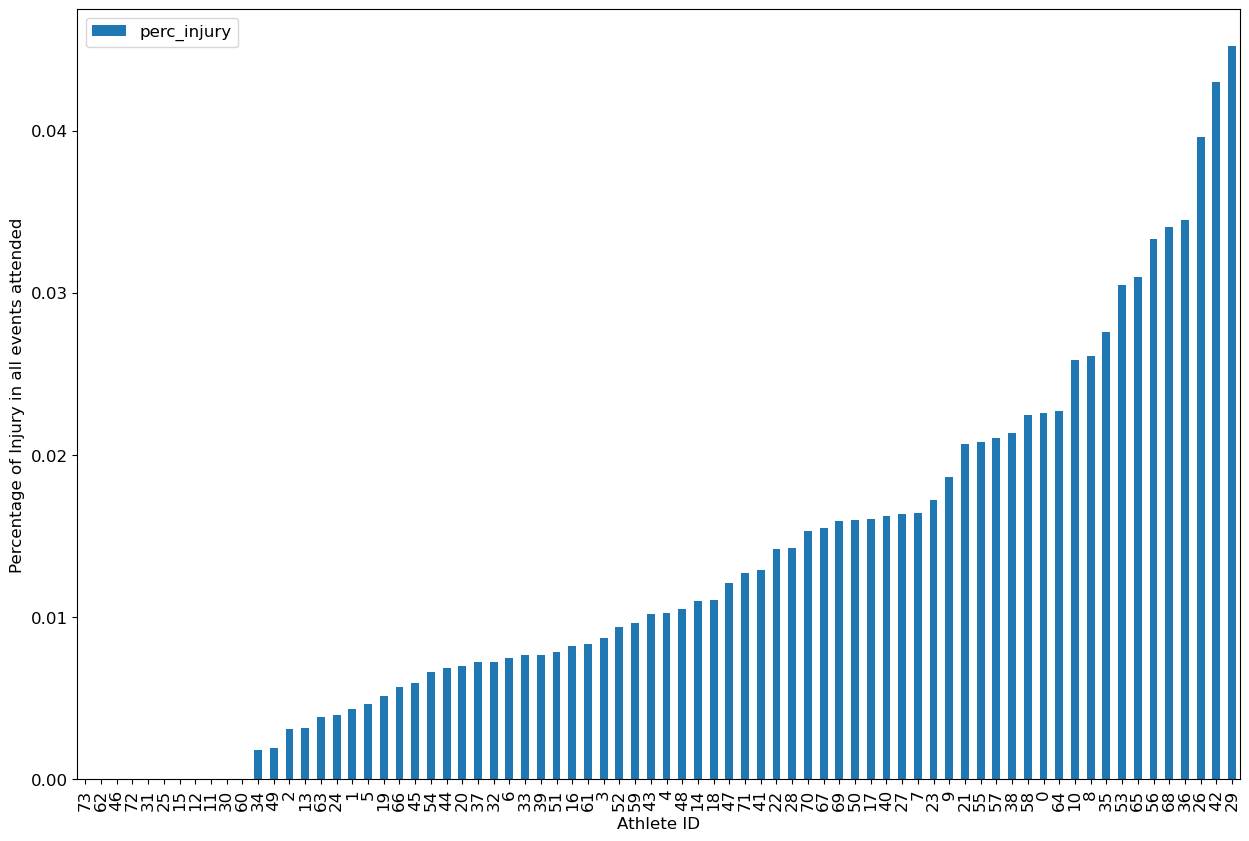

In [5]:
perc_injured_per_athlete.plot.bar('Athlete ID','perc_injury', figsize = (15,10))
plt.xlabel('Athlete ID')
plt.ylabel('Percentage of Injury in all events attended')
plt.savefig('../figures/athlete_injury.png')
plt.show()

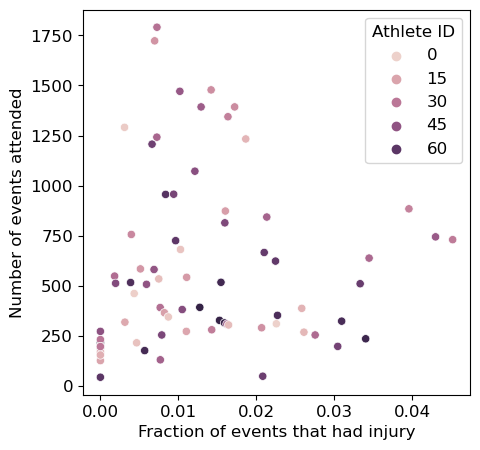

In [6]:
# find which athletes competed in a lot of games AND get injured more frequently
plt.figure(figsize=(5,5))
sns.scatterplot(data=perc_injured_per_athlete, x='perc_injury', y='Date', hue='Athlete ID')
plt.xlabel('Fraction of events that had injury')
plt.ylabel('Number of events attended')
plt.savefig('../figures/athlete scatter.png')

plt.show()

In [99]:
df_29 = df[df['Athlete ID'] == 29]
df_29.head()

nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
17545           1.0       9.1      0.0          0.0           0.0   
17546           1.0       8.6      2.0          2.0           0.0   
17547           1.0       8.4      0.0          0.0           0.0   
17548           1.0       9.7      1.2          1.0           0.0   
17549           0.0       0.0      0.0          0.0           0.0   

       strength training  hours alternative  perceived exertion  \
17545                0.0                0.0                0.09   
17546                0.0                0.0                0.11   
17547                0.0                0.0                0.09   
17548                0.0                0.0                0.12   
17549                0.0                0.0               -0.01   

       perceived trainingSuccess  perceived recovery  ...  km Z5-T1-T2.6  \
17545                       0.00                0.18  ...            0.0   
17546                       0.00                0.18  ...            1.0   
17547                       0.00                0.17  ...            0.0   
17548                       0.00                0.19  ...            1.4   
17549                      -0.01               -0.01  ...            0.0   

       km sprinting.6  strength training.6  hours alternative.6  \
17545             0.0                  0.0                  0.0   
17546             0.2                  0.0                  0.0   
17547             0.0                  0.0                  0.0   
17548             0.0                  0.0                  0.0   
17549             0.0                  0.0                  0.0   

       perceived exertion.6  perceived trainingSuccess.6  \
17545                  0.09                         0.00   
17546                  0.10                         0.00   
17547                  0.09                         0.00   
17548                  0.12                         0.00   
17549                 -0.01                        -0.01   

       perceived recovery.6  Athlete ID  injury  Date  
17545                  0.16          29       0     0  
17546                  0.19          29       0     1  
17547                  0.18          29       0     2  
17548                  0.18          29       0     3  
17549                 -0.01          29       0     4  

[5 rows x 73 columns]

In [8]:
df_29.shape

(730, 73)

In [9]:
df_29.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 17545 to 42445
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nr. sessions                 730 non-null    float64
 1   total km                     730 non-null    float64
 2   km Z3-4                      730 non-null    float64
 3   km Z5-T1-T2                  730 non-null    float64
 4   km sprinting                 730 non-null    float64
 5   strength training            730 non-null    float64
 6   hours alternative            730 non-null    float64
 7   perceived exertion           730 non-null    float64
 8   perceived trainingSuccess    730 non-null    float64
 9   perceived recovery           730 non-null    float64
 10  nr. sessions.1               730 non-null    float64
 11  total km.1                   730 non-null    float64
 12  km Z3-4.1                    730 non-null    float64
 13  km Z5-T1-T2.1 

In [10]:
df.columns

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

In [11]:
df_29['Date'].describe()

count     730.000000
mean     1127.747945
std       900.112011
min         0.000000
25%       182.250000
50%       931.500000
75%      1710.750000
max      2651.000000
Name: Date, dtype: float64

### Explore target variable ###

In [14]:
# explore target variable
df_29['injury'].value_counts()

0    697
1     33
Name: injury, dtype: int64

In [13]:
df_29['injury'].value_counts(normalize=True)

0    0.954795
1    0.045205
Name: injury, dtype: float64

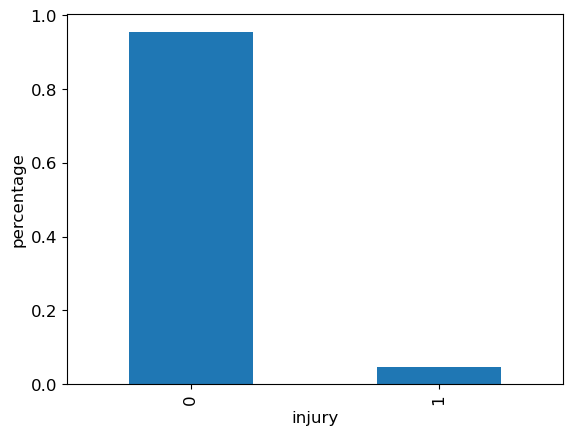

In [15]:
pd.value_counts(df_29['injury'],normalize=True).plot.bar()
plt.xlabel('injury')
plt.ylabel('percentage')
plt.savefig('../figures/injury.png')
plt.show()

#### Explore the Features ####

focus on the features in nr. sessions (the session right before the event)

In [12]:
other_cols = ['Athlete ID','injury', 'Date']
cont_ftrs = [col for col in df if col not in other_cols]
cat_ftrs = ['Athlete ID']

nr. sessions
count    730.000000
mean       0.879452
std        0.522986
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions, dtype: float64


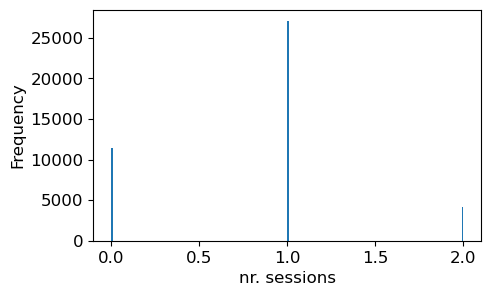

total km
count    730.000000
mean       5.383699
std        4.937621
min        0.000000
25%        0.000000
50%        5.900000
75%        8.800000
max       45.800000
Name: total km, dtype: float64


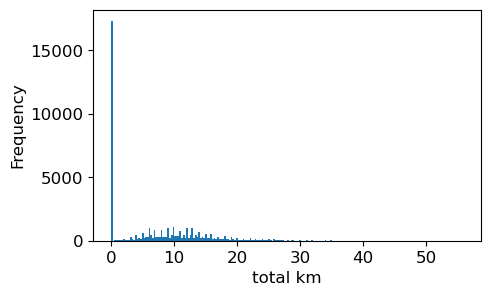

km Z3-4
count    730.000000
mean       0.396712
std        1.284364
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.300000
Name: km Z3-4, dtype: float64


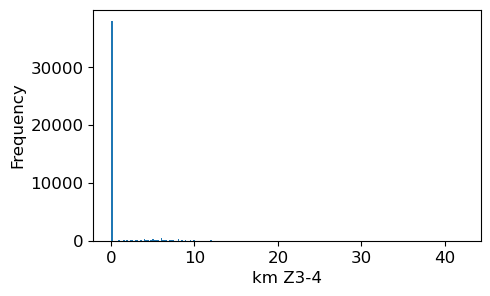

km Z5-T1-T2
count    730.000000
mean       0.336849
std        1.041840
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.100000
Name: km Z5-T1-T2, dtype: float64


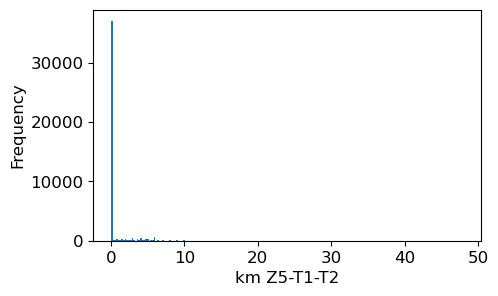

km sprinting
count    730.000000
mean       0.164110
std        0.462325
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: km sprinting, dtype: float64


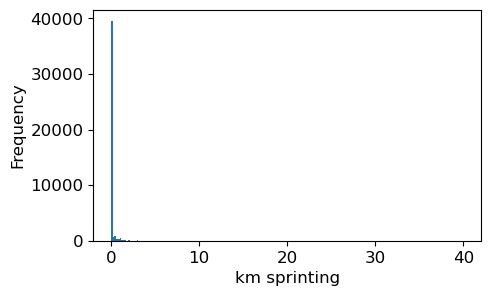

strength training
count    730.000000
mean       0.126027
std        0.359861
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training, dtype: float64


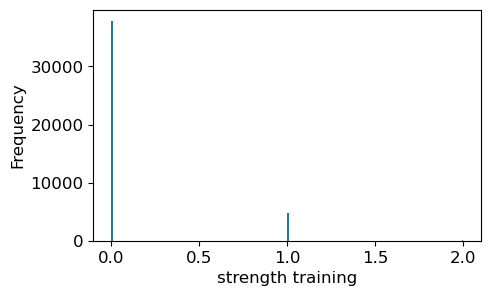

hours alternative
count    730.000000
mean       0.182041
std        0.484472
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative, dtype: float64


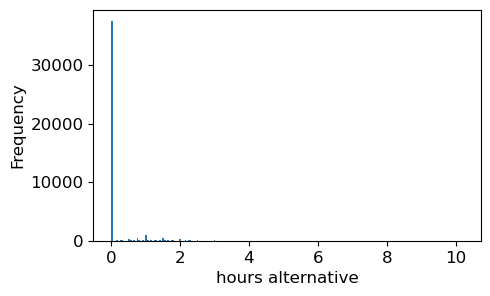

perceived exertion
count    730.000000
mean       0.212753
std        0.231519
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.360000
max        1.000000
Name: perceived exertion, dtype: float64


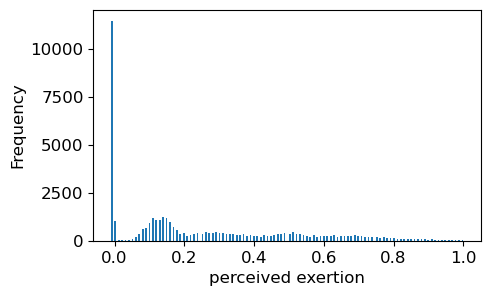

perceived trainingSuccess
count    730.000000
mean       0.398301
std        0.412572
min       -0.010000
25%        0.000000
50%        0.300000
75%        0.840000
max        1.000000
Name: perceived trainingSuccess, dtype: float64


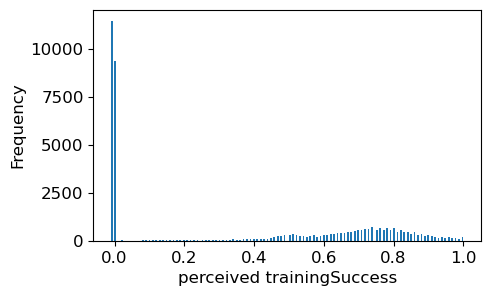

perceived recovery
count    730.000000
mean       0.136356
std        0.105737
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery, dtype: float64


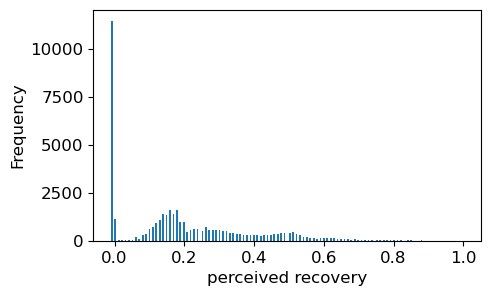

nr. sessions.1
count    730.000000
mean       0.882192
std        0.536550
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.1, dtype: float64


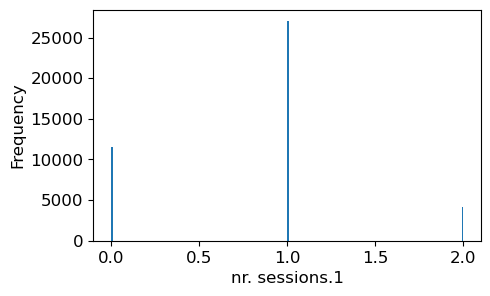

total km.1
count    730.000000
mean       5.355479
std        5.069257
min        0.000000
25%        0.000000
50%        5.800000
75%        8.700000
max       45.800000
Name: total km.1, dtype: float64


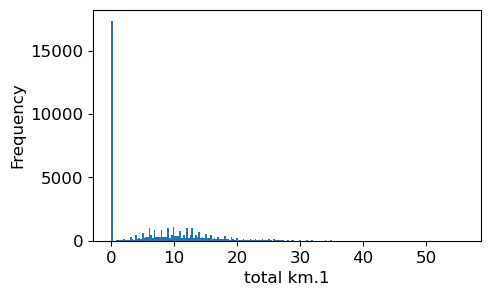

km Z3-4.1
count    730.000000
mean       0.399726
std        1.285393
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.300000
Name: km Z3-4.1, dtype: float64


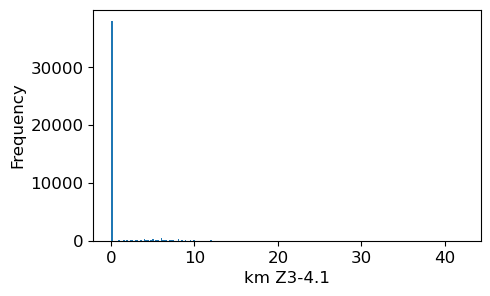

km Z5-T1-T2.1
count    730.000000
mean       0.325068
std        1.041137
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.100000
Name: km Z5-T1-T2.1, dtype: float64


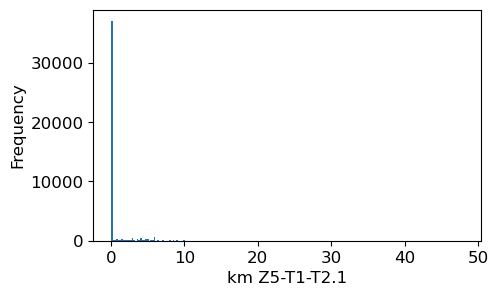

km sprinting.1
count    730.000000
mean       0.151233
std        0.416866
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.400000
Name: km sprinting.1, dtype: float64


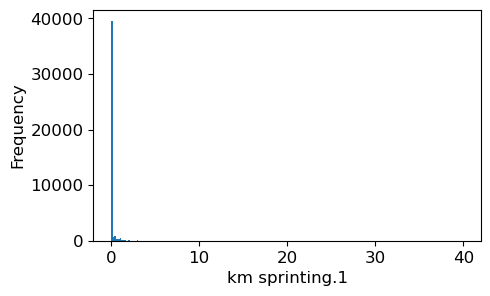

strength training.1
count    730.000000
mean       0.131507
std        0.369212
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.1, dtype: float64


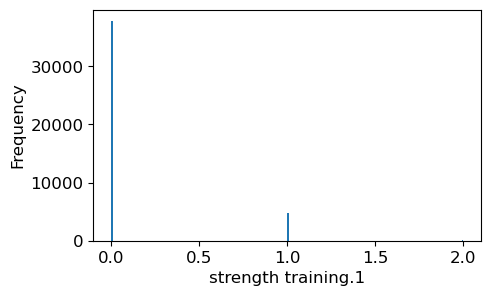

hours alternative.1
count    730.000000
mean       0.200192
std        0.514653
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative.1, dtype: float64


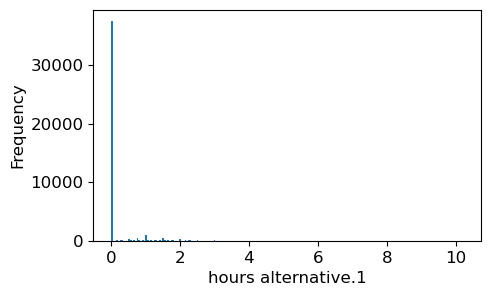

perceived exertion.1
count    730.000000
mean       0.211356
std        0.229627
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.1, dtype: float64


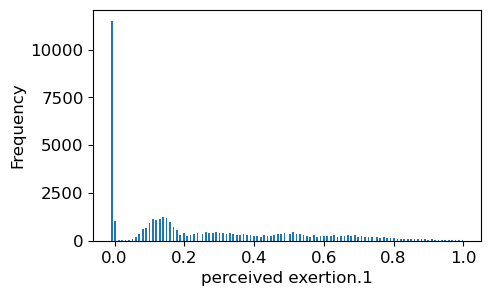

perceived trainingSuccess.1
count    730.000000
mean       0.396562
std        0.411312
min       -0.010000
25%        0.000000
50%        0.300000
75%        0.840000
max        0.980000
Name: perceived trainingSuccess.1, dtype: float64


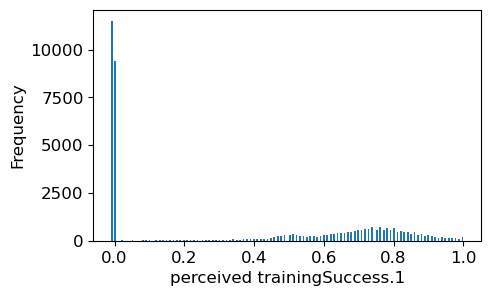

perceived recovery.1
count    730.000000
mean       0.135795
std        0.106570
min       -0.010000
25%        0.050000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.1, dtype: float64


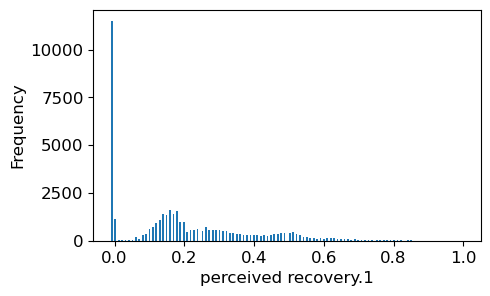

nr. sessions.2
count    730.000000
mean       0.883562
std        0.530423
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.2, dtype: float64


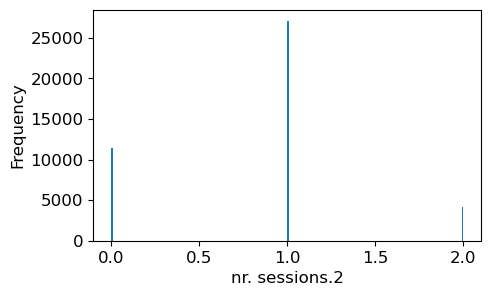

total km.2
count    730.000000
mean       5.388767
std        4.923495
min        0.000000
25%        0.000000
50%        5.900000
75%        8.700000
max       45.800000
Name: total km.2, dtype: float64


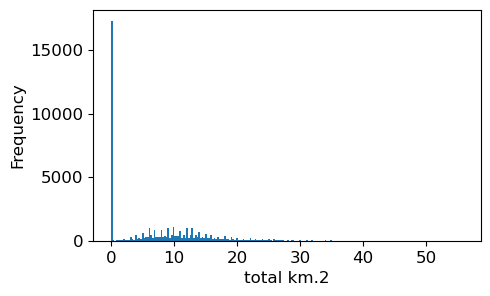

km Z3-4.2
count    730.000000
mean       0.412877
std        1.321542
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        9.000000
Name: km Z3-4.2, dtype: float64


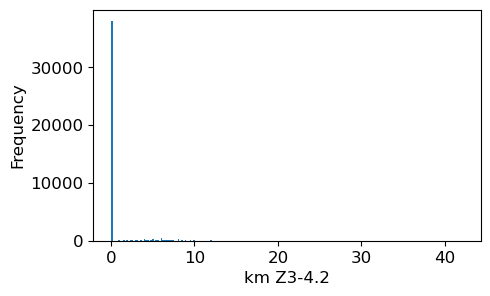

km Z5-T1-T2.2
count    730.000000
mean       0.359589
std        1.113120
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.2, dtype: float64


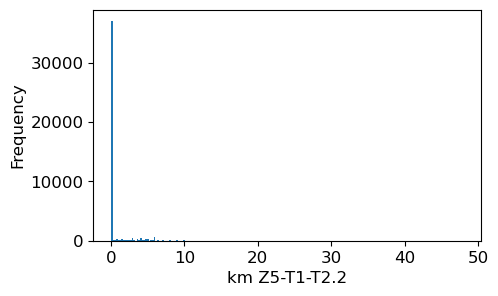

km sprinting.2
count    730.000000
mean       0.150411
std        0.407719
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.400000
Name: km sprinting.2, dtype: float64


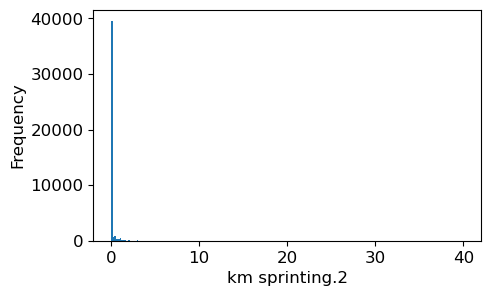

strength training.2
count    730.000000
mean       0.126027
std        0.363653
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.2, dtype: float64


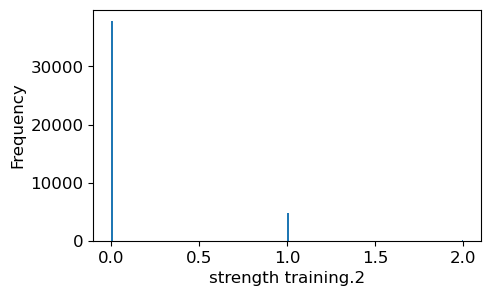

hours alternative.2
count    730.000000
mean       0.188205
std        0.492770
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative.2, dtype: float64


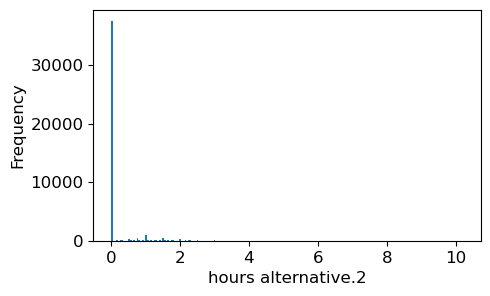

perceived exertion.2
count    730.000000
mean       0.211658
std        0.229077
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.2, dtype: float64


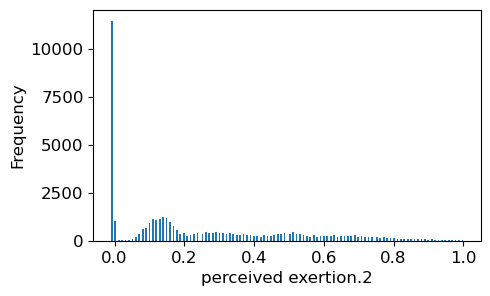

perceived trainingSuccess.2
count    730.000000
mean       0.398795
std        0.412014
min       -0.010000
25%        0.000000
50%        0.325000
75%        0.840000
max        0.990000
Name: perceived trainingSuccess.2, dtype: float64


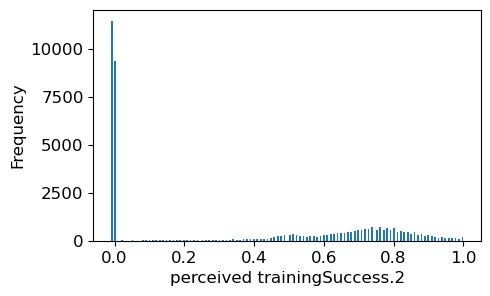

perceived recovery.2
count    730.000000
mean       0.135589
std        0.104746
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.2, dtype: float64


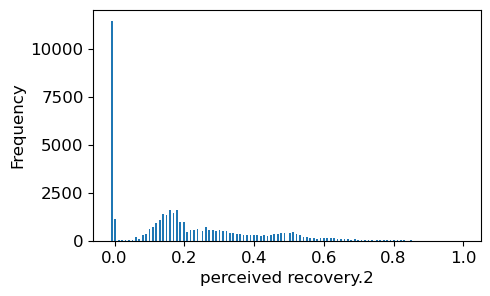

nr. sessions.3
count    730.000000
mean       0.880822
std        0.532396
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.3, dtype: float64


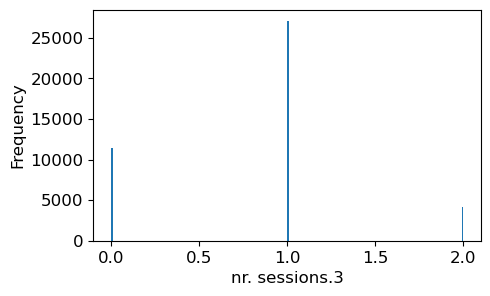

total km.3
count    730.000000
mean       5.471507
std        5.297693
min        0.000000
25%        0.000000
50%        5.900000
75%        8.775000
max       57.000000
Name: total km.3, dtype: float64


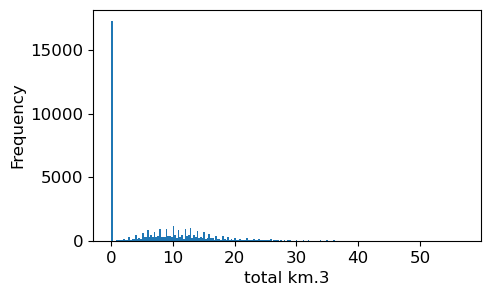

km Z3-4.3
count    730.000000
mean       0.412055
std        1.330333
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.3, dtype: float64


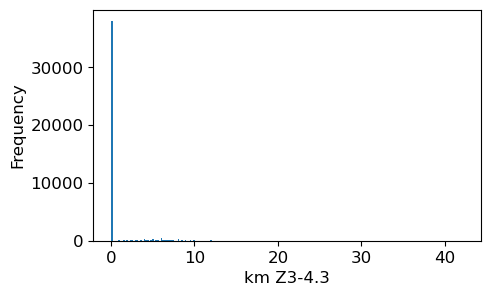

km Z5-T1-T2.3
count    730.000000
mean       0.353288
std        1.105800
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.600000
Name: km Z5-T1-T2.3, dtype: float64


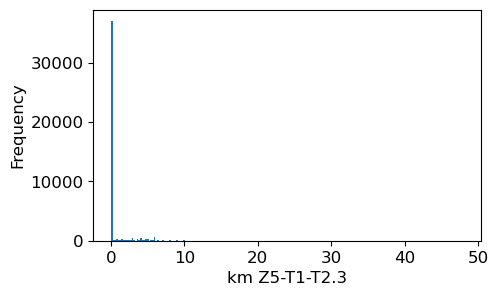

km sprinting.3
count    730.000000
mean       0.161370
std        0.470663
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: km sprinting.3, dtype: float64


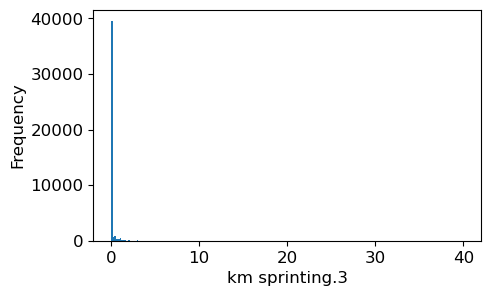

strength training.3
count    730.000000
mean       0.126027
std        0.359861
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.3, dtype: float64


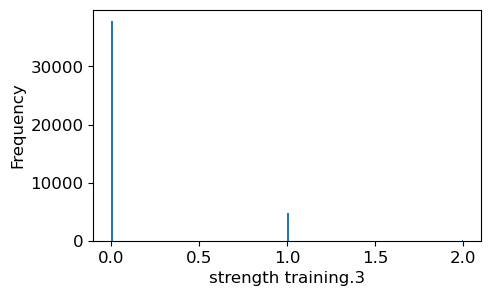

hours alternative.3
count    730.000000
mean       0.192767
std        0.504683
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative.3, dtype: float64


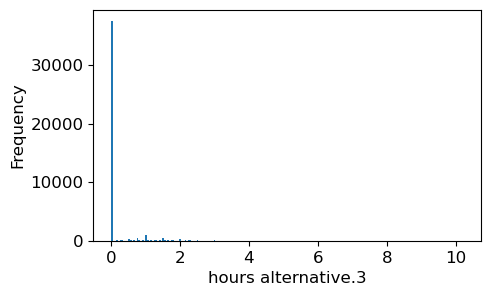

perceived exertion.3
count    730.000000
mean       0.215589
std        0.234720
min       -0.010000
25%        0.052500
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.3, dtype: float64


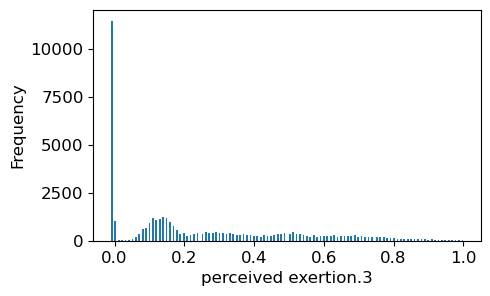

perceived trainingSuccess.3
count    730.000000
mean       0.398370
std        0.410747
min       -0.010000
25%        0.000000
50%        0.355000
75%        0.837500
max        0.980000
Name: perceived trainingSuccess.3, dtype: float64


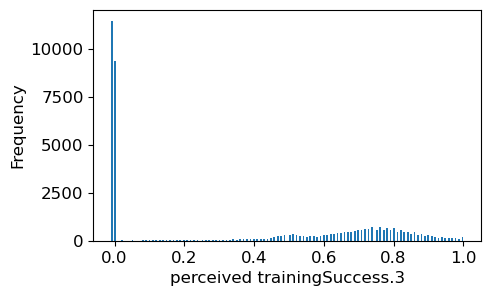

perceived recovery.3
count    730.000000
mean       0.136945
std        0.106660
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.3, dtype: float64


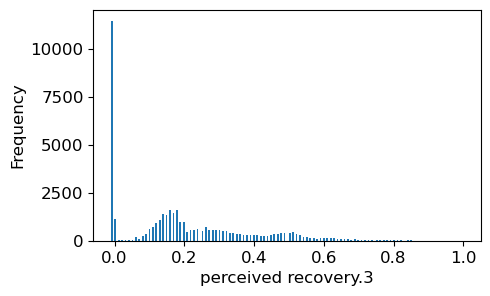

nr. sessions.4
count    730.000000
mean       0.879452
std        0.538493
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.4, dtype: float64


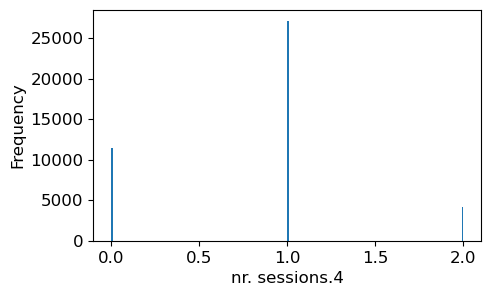

total km.4
count    730.000000
mean       5.372877
std        4.967467
min        0.000000
25%        0.000000
50%        5.800000
75%        8.700000
max       45.800000
Name: total km.4, dtype: float64


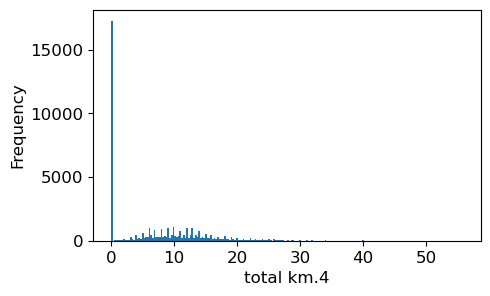

km Z3-4.4
count    730.000000
mean       0.429589
std        1.347385
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.4, dtype: float64


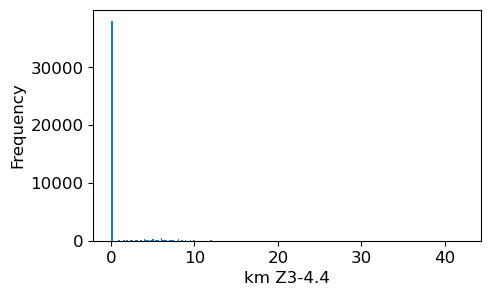

km Z5-T1-T2.4
count    730.000000
mean       0.328493
std        1.040317
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.4, dtype: float64


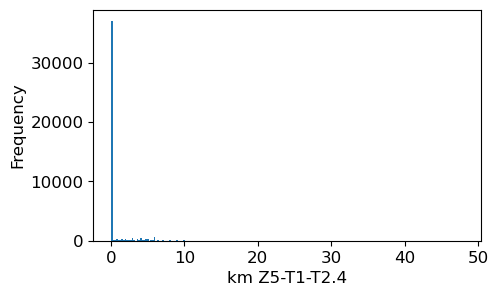

km sprinting.4
count    730.000000
mean       0.153288
std        0.435681
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.600000
Name: km sprinting.4, dtype: float64


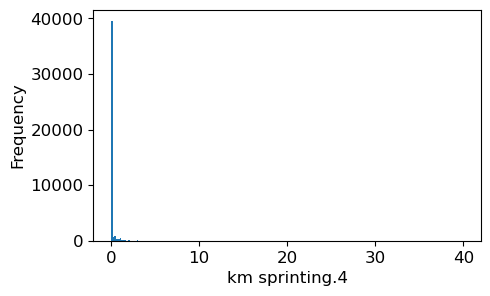

strength training.4
count    730.000000
mean       0.127397
std        0.361281
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.4, dtype: float64


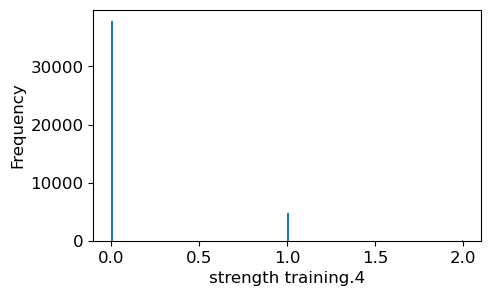

hours alternative.4
count    730.000000
mean       0.190151
std        0.493474
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.830000
Name: hours alternative.4, dtype: float64


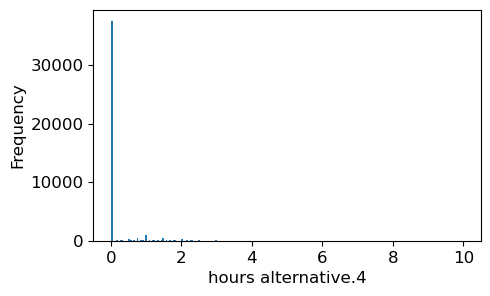

perceived exertion.4
count    730.000000
mean       0.213986
std        0.232249
min       -0.010000
25%        0.052500
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.4, dtype: float64


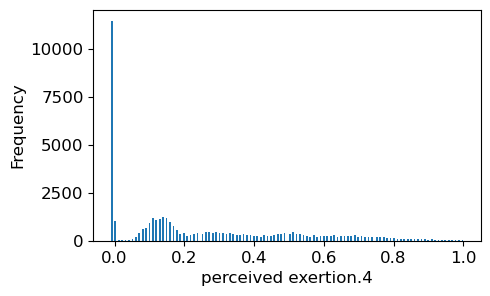

perceived trainingSuccess.4
count    730.000000
mean       0.392836
std        0.409310
min       -0.010000
25%        0.000000
50%        0.245000
75%        0.830000
max        0.980000
Name: perceived trainingSuccess.4, dtype: float64


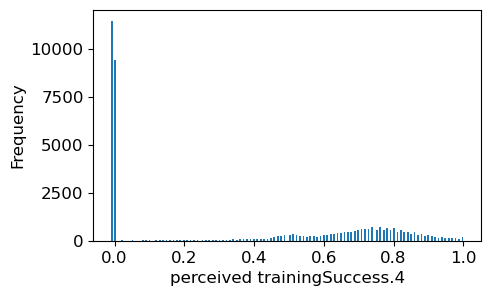

perceived recovery.4
count    730.000000
mean       0.135603
std        0.106501
min       -0.010000
25%        0.050000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.4, dtype: float64


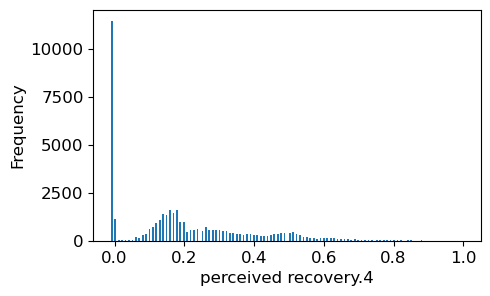

nr. sessions.5
count    730.000000
mean       0.879452
std        0.538493
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.5, dtype: float64


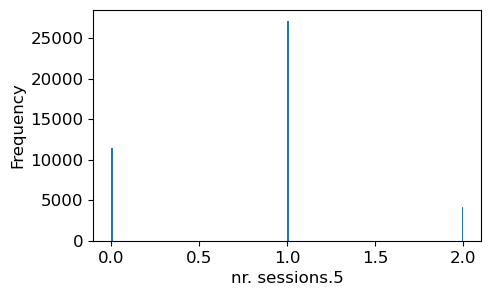

total km.5
count    730.000000
mean       5.473014
std        5.013977
min        0.000000
25%        0.000000
50%        5.800000
75%        8.975000
max       45.800000
Name: total km.5, dtype: float64


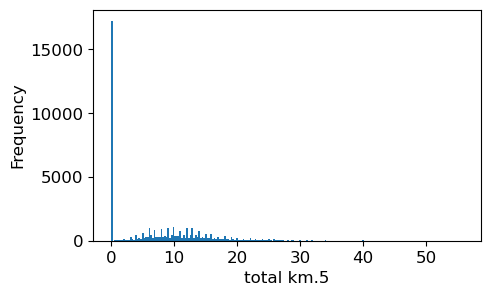

km Z3-4.5
count    730.000000
mean       0.436438
std        1.352136
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.5, dtype: float64


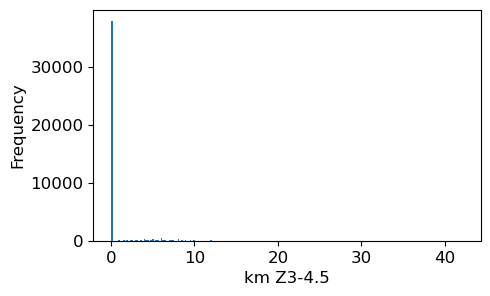

km Z5-T1-T2.5
count    730.000000
mean       0.368630
std        1.114299
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.5, dtype: float64


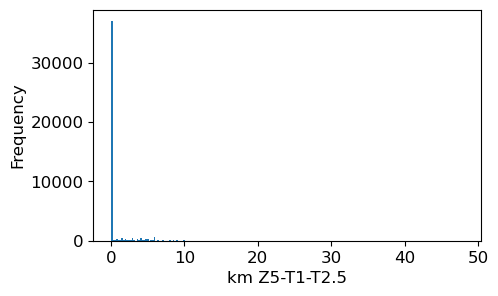

km sprinting.5
count    730.000000
mean       0.159178
std        0.472282
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.900000
Name: km sprinting.5, dtype: float64


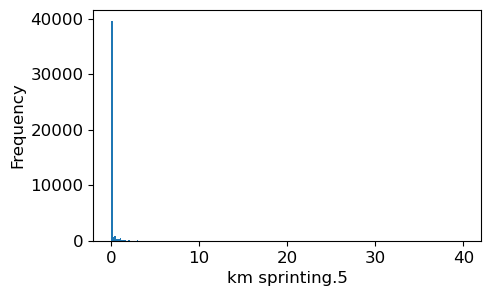

strength training.5
count    730.000000
mean       0.128767
std        0.362691
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.5, dtype: float64


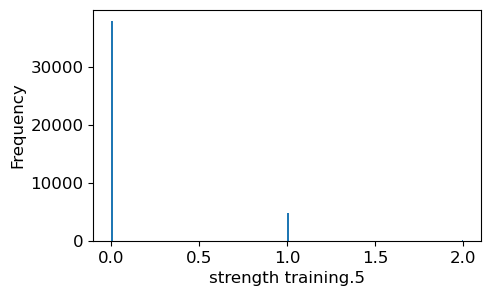

hours alternative.5
count    730.000000
mean       0.182616
std        0.487482
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.830000
Name: hours alternative.5, dtype: float64


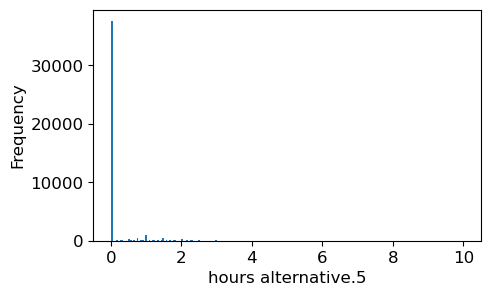

perceived exertion.5
count    730.000000
mean       0.216438
std        0.234405
min       -0.010000
25%        0.042500
50%        0.110000
75%        0.380000
max        1.000000
Name: perceived exertion.5, dtype: float64


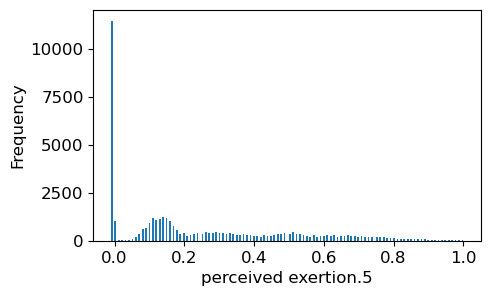

perceived trainingSuccess.5
count    730.000000
mean       0.395740
std        0.409973
min       -0.010000
25%        0.000000
50%        0.300000
75%        0.837500
max        0.990000
Name: perceived trainingSuccess.5, dtype: float64


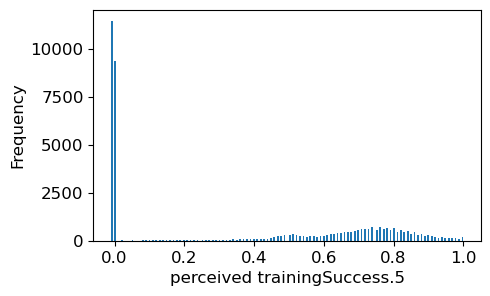

perceived recovery.5
count    730.000000
mean       0.136973
std        0.107939
min       -0.010000
25%        0.050000
50%        0.160000
75%        0.190000
max        0.750000
Name: perceived recovery.5, dtype: float64


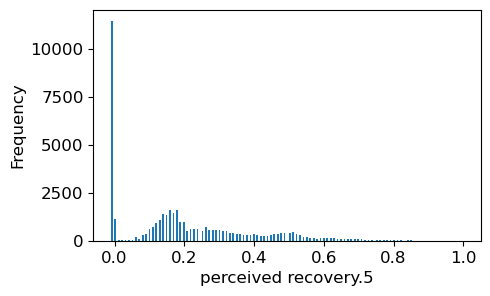

nr. sessions.6
count    730.000000
mean       0.886301
std        0.533594
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.6, dtype: float64


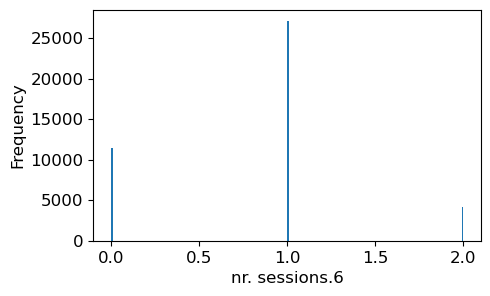

total km.6
count    730.000000
mean       5.376438
std        4.940412
min        0.000000
25%        0.000000
50%        5.800000
75%        8.700000
max       45.800000
Name: total km.6, dtype: float64


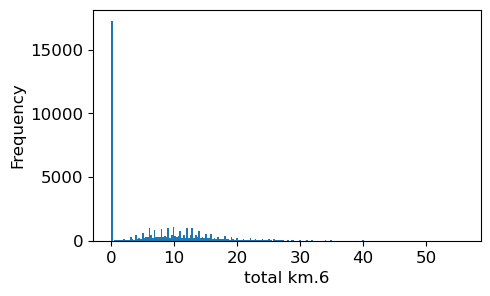

km Z3-4.6
count    730.000000
mean       0.443836
std        1.367112
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.6, dtype: float64


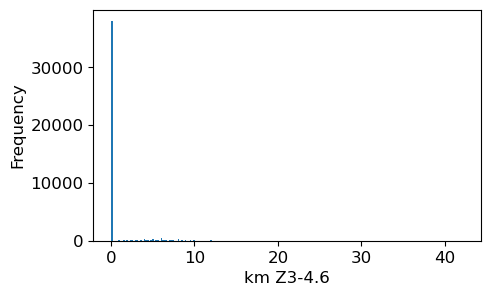

km Z5-T1-T2.6
count    730.000000
mean       0.337945
std        1.069209
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.6, dtype: float64


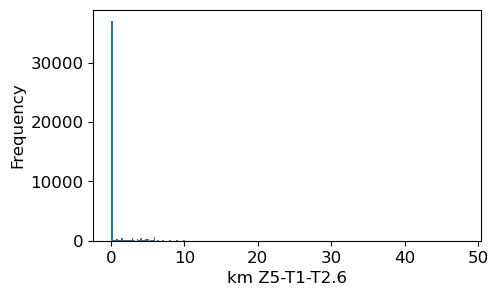

km sprinting.6
count    730.000000
mean       0.150411
std        0.419460
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.400000
Name: km sprinting.6, dtype: float64


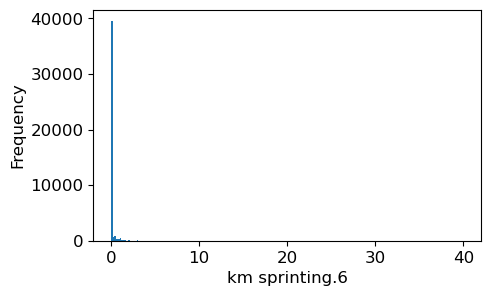

strength training.6
count    730.000000
mean       0.132877
std        0.366855
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.6, dtype: float64


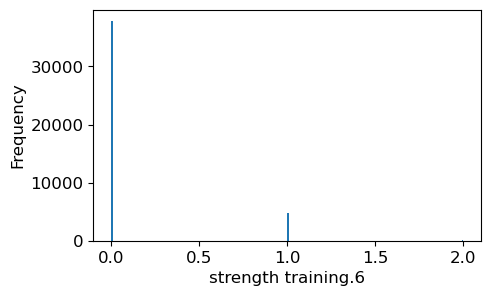

hours alternative.6
count    730.000000
mean       0.202260
std        0.520476
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.170000
Name: hours alternative.6, dtype: float64


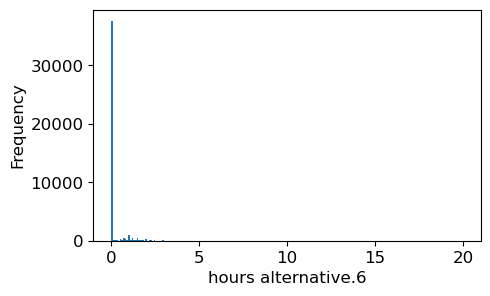

perceived exertion.6
count    730.000000
mean       0.220301
std        0.236544
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.380000
max        1.000000
Name: perceived exertion.6, dtype: float64


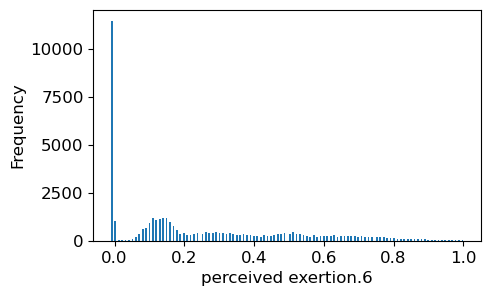

perceived trainingSuccess.6
count    730.000000
mean       0.399014
std        0.408471
min       -0.010000
25%        0.000000
50%        0.395000
75%        0.830000
max        0.980000
Name: perceived trainingSuccess.6, dtype: float64


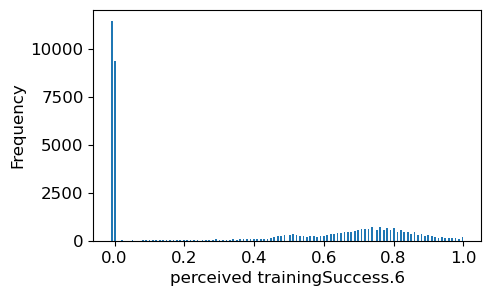

perceived recovery.6
count    730.000000
mean       0.139575
std        0.107532
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.750000
Name: perceived recovery.6, dtype: float64


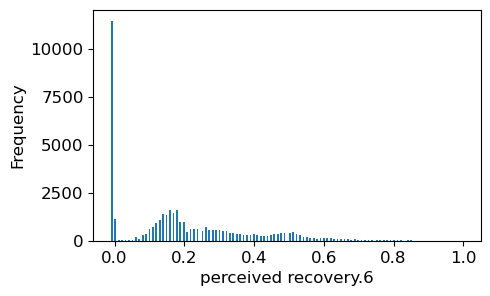

Athlete ID
count    730.0
mean      29.0
std        0.0
min       29.0
25%       29.0
50%       29.0
75%       29.0
max       29.0
Name: Athlete ID, dtype: float64


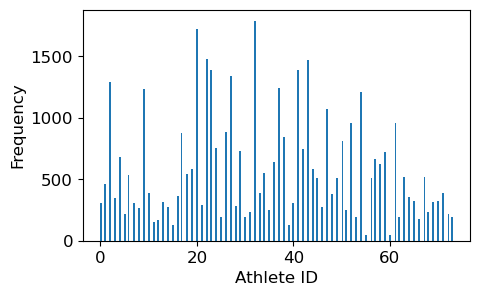

injury
count    730.000000
mean       0.045205
std        0.207897
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: injury, dtype: float64


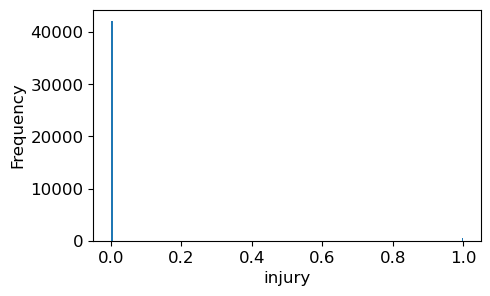

Date
count     730.000000
mean     1127.747945
std       900.112011
min         0.000000
25%       182.250000
50%       931.500000
75%      1710.750000
max      2651.000000
Name: Date, dtype: float64


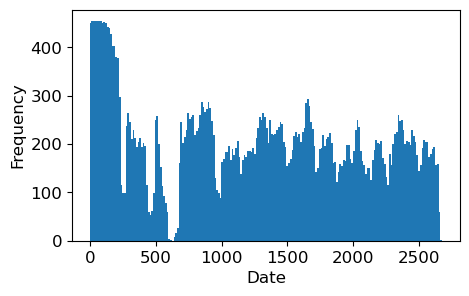

In [16]:
for ftr in df_29.columns:
    print(ftr)
    print(df_29[ftr].describe())
    plt.figure(figsize=(5,3))
    plt.hist(df_29[ftr], bins = int(np.sqrt(df.shape[0])))
    plt.xlabel(ftr)
    plt.ylabel('Frequency')
    plt.savefig('../figures/{}.png'.format(ftr))
    plt.show()

count    730.000000
mean       5.383699
std        4.937621
min        0.000000
25%        0.000000
50%        5.900000
75%        8.800000
max       45.800000
Name: total km, dtype: float64


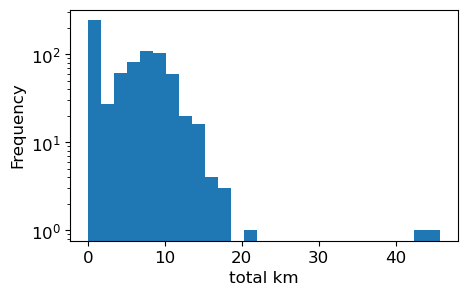

In [21]:
ftr = 'total km'
print(df_29[ftr].describe())
plt.figure(figsize=(5,3))
plt.hist(df_29[ftr], bins = int(np.sqrt(df_29.shape[0])))
plt.yscale('log')
plt.xlabel(ftr)
plt.ylabel('Frequency')
plt.savefig('../figures/{}.png'.format(ftr))
plt.show()

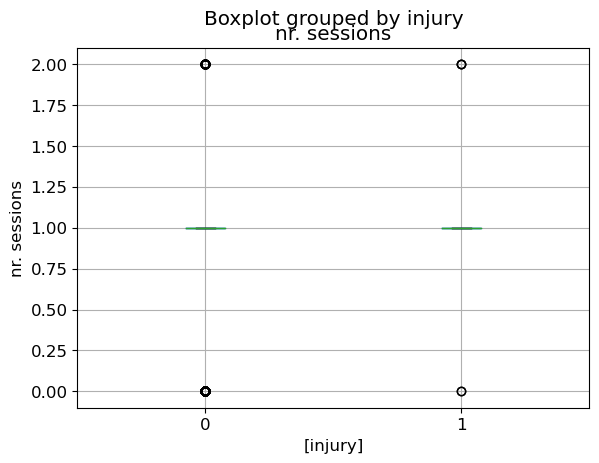

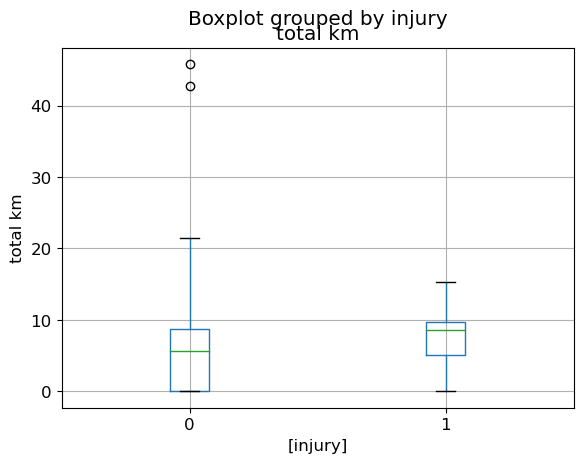

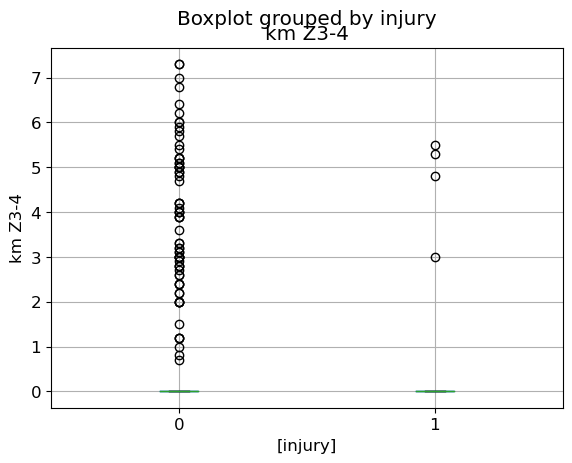

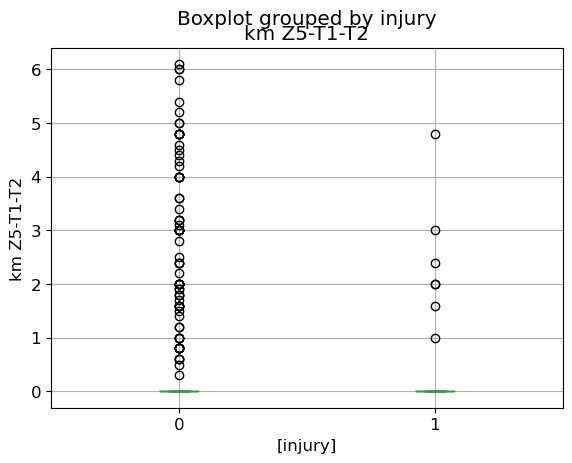

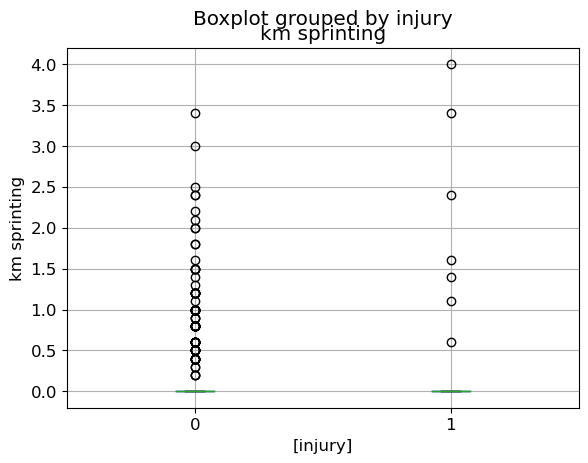

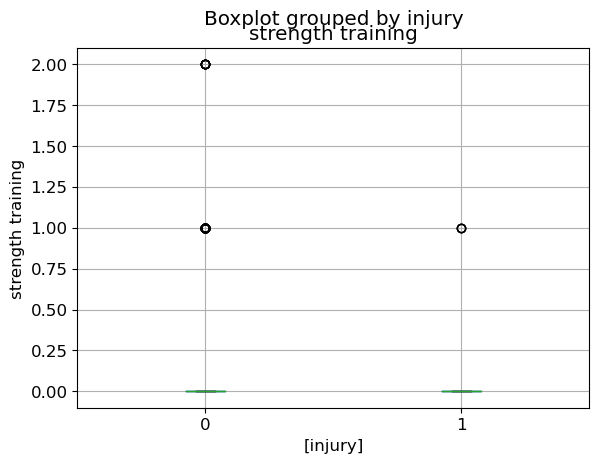

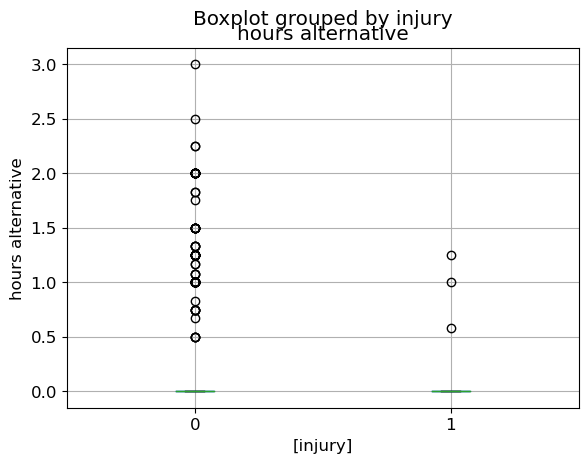

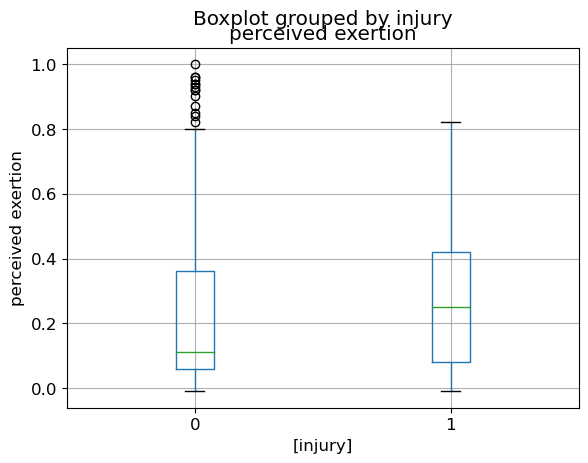

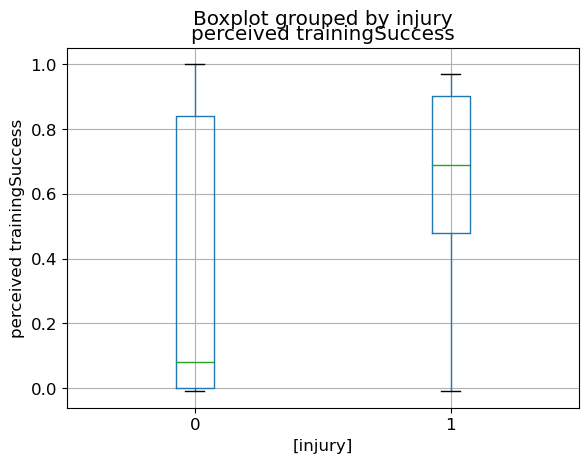

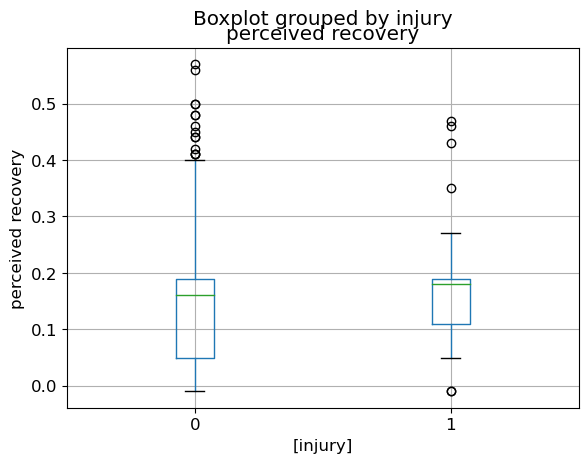

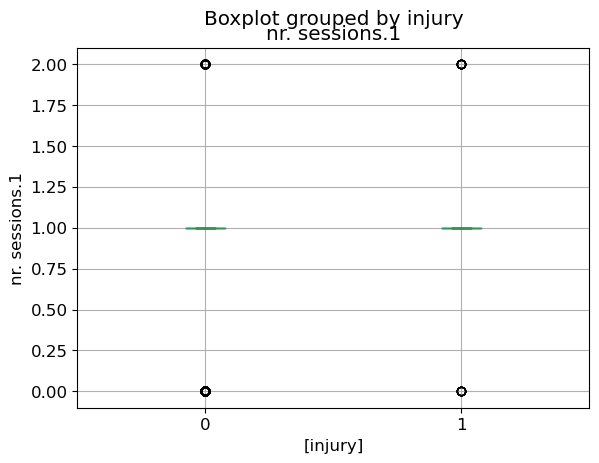

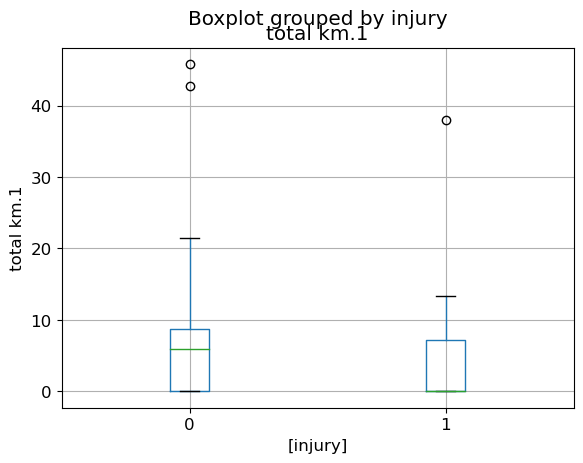

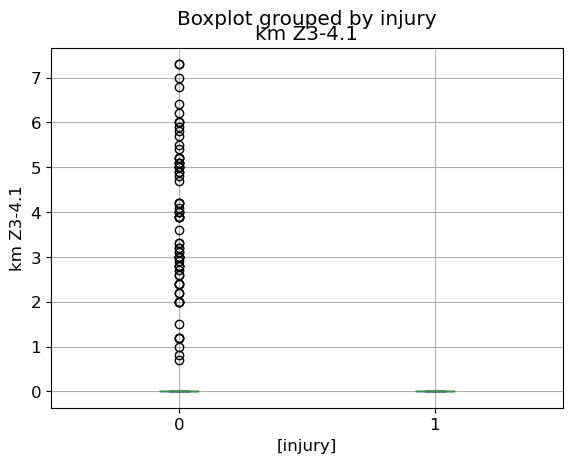

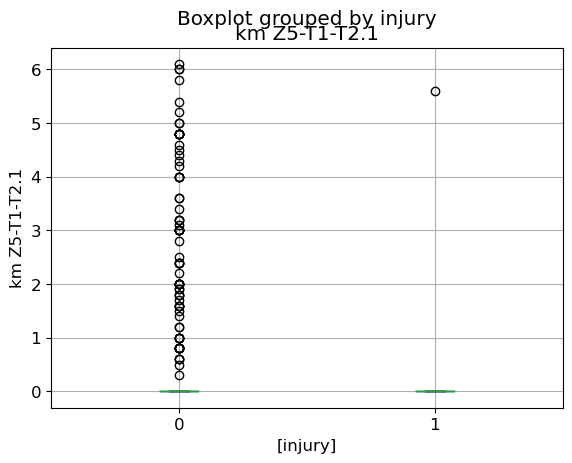

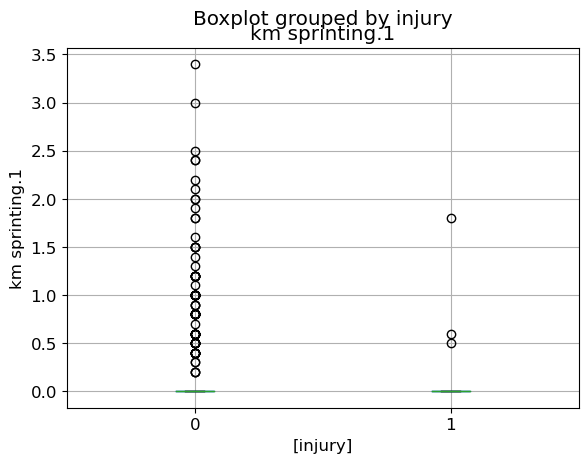

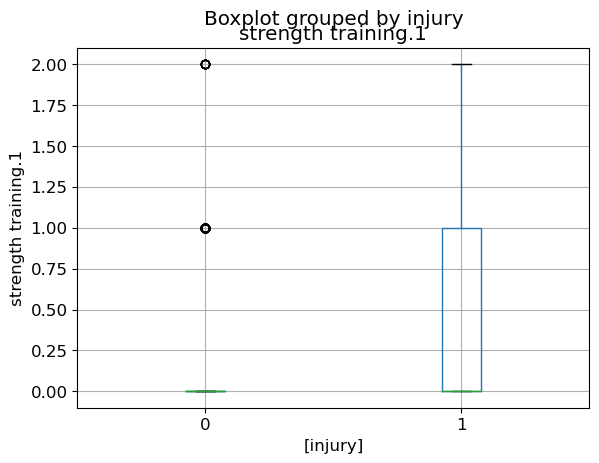

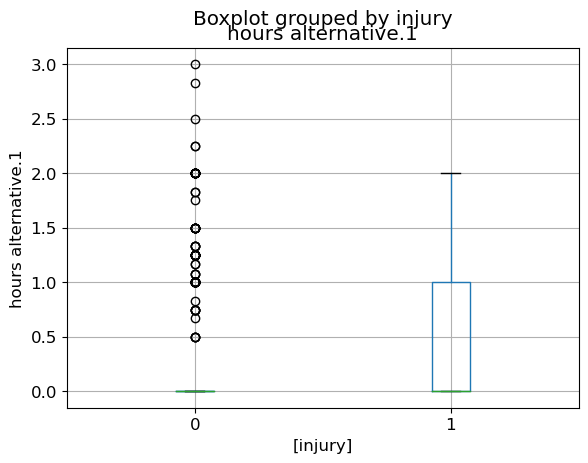

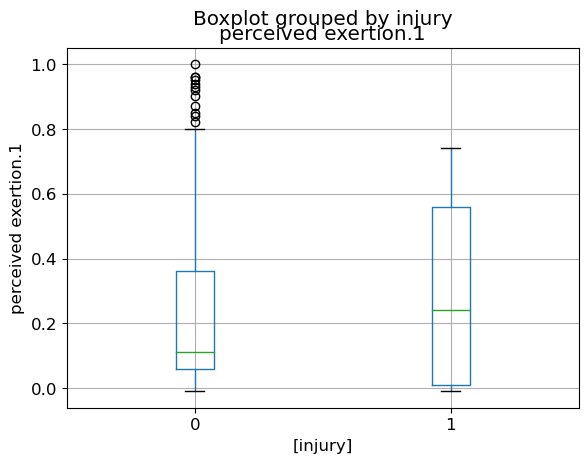

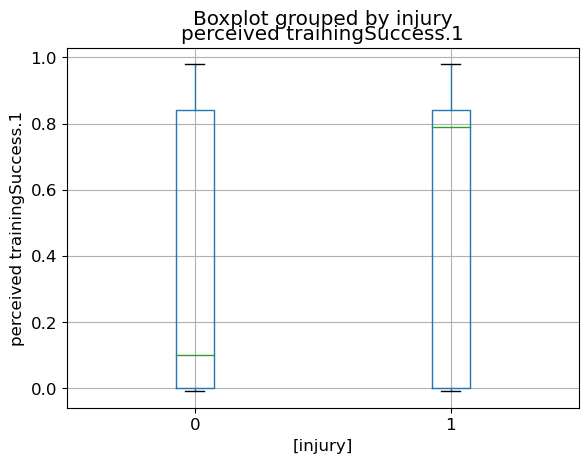

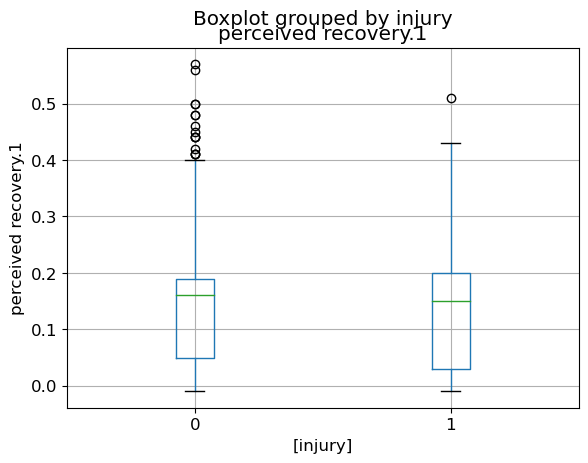

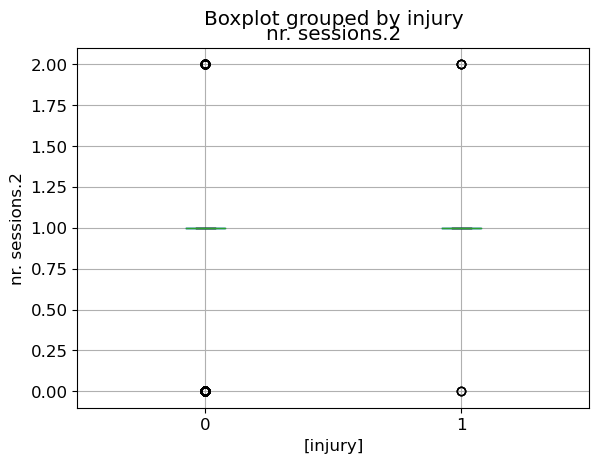

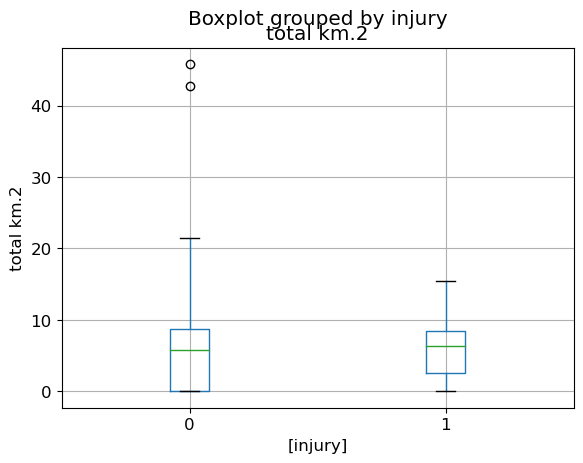

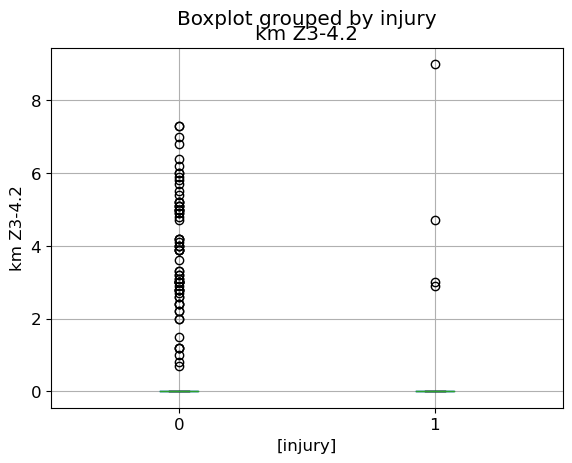

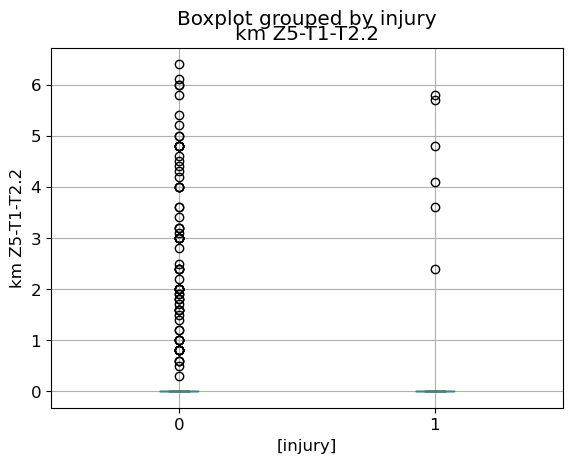

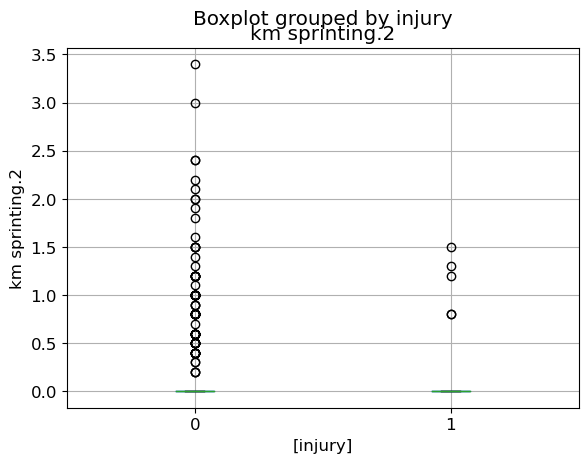

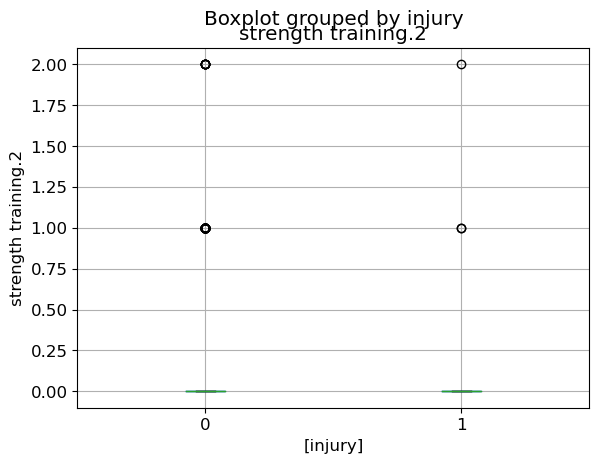

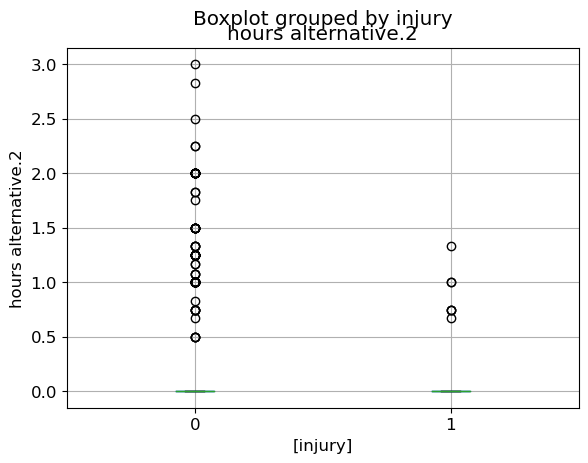

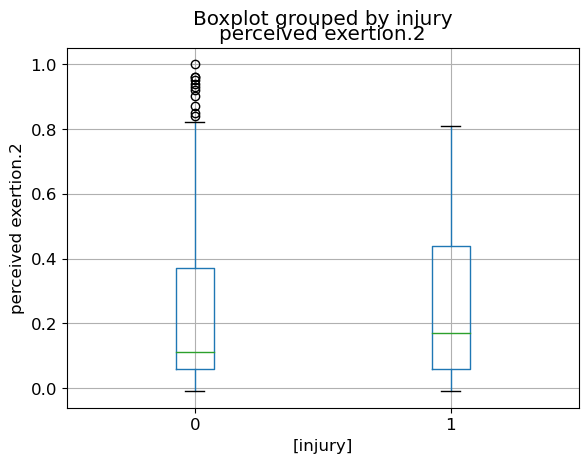

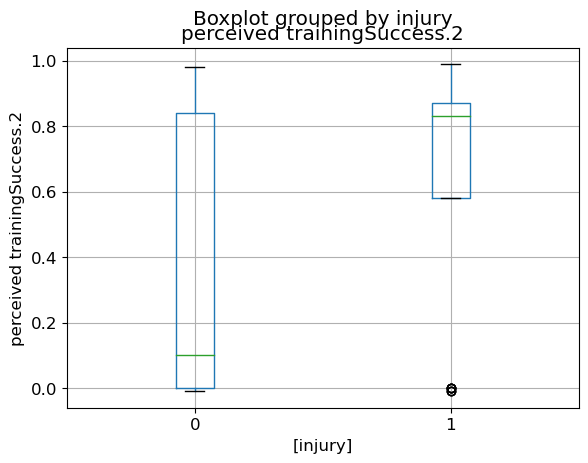

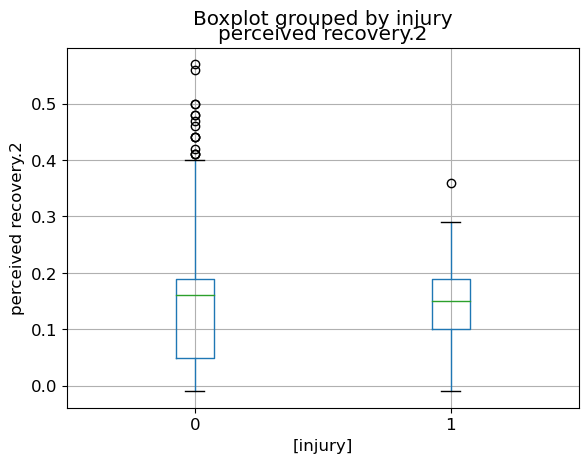

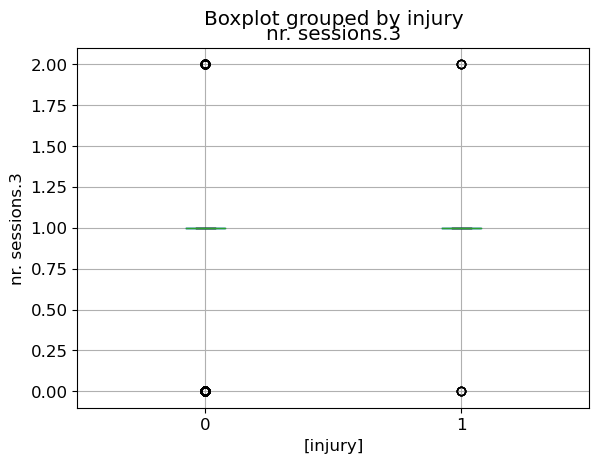

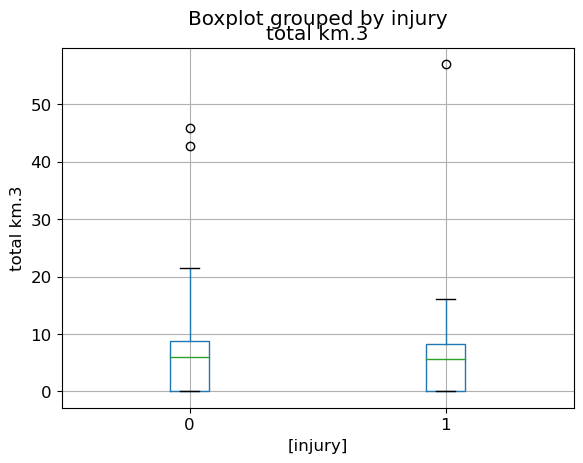

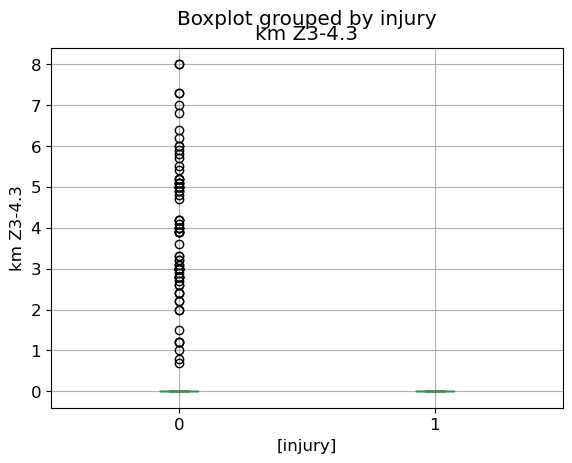

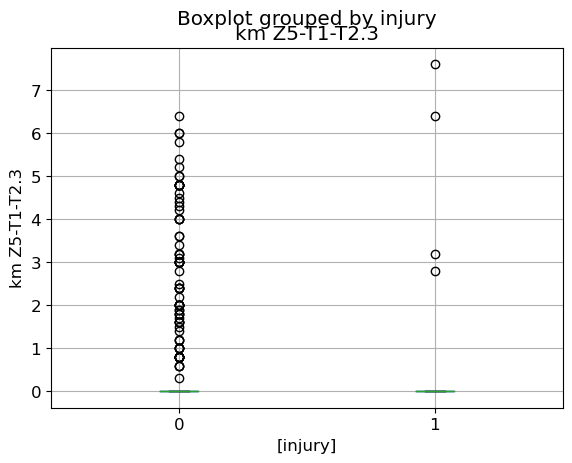

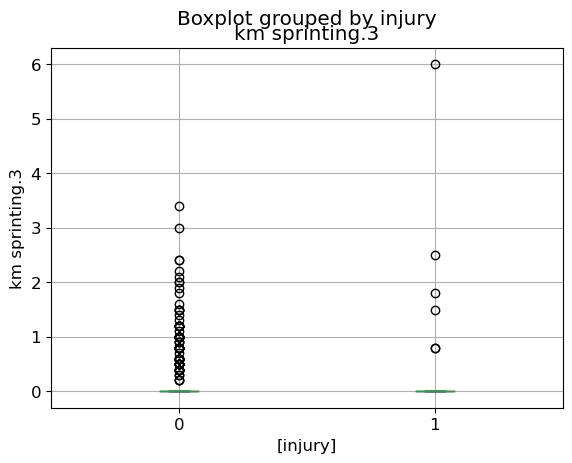

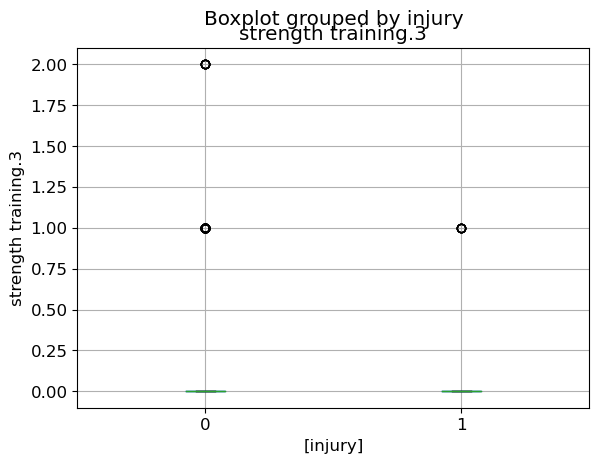

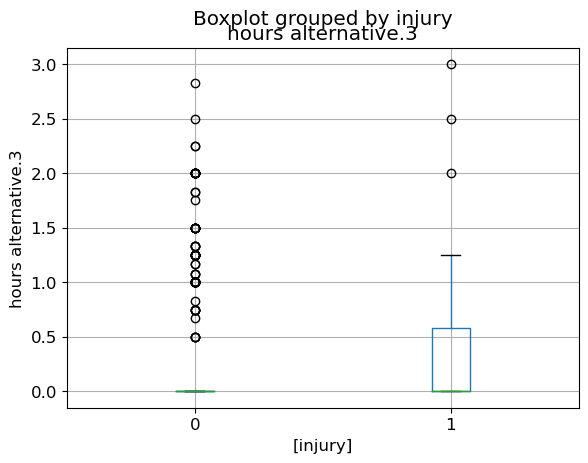

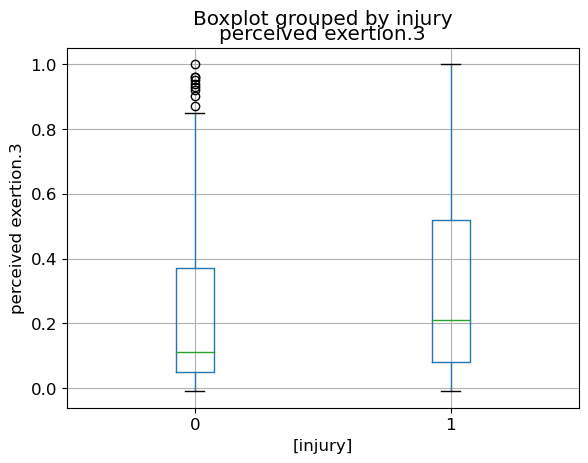

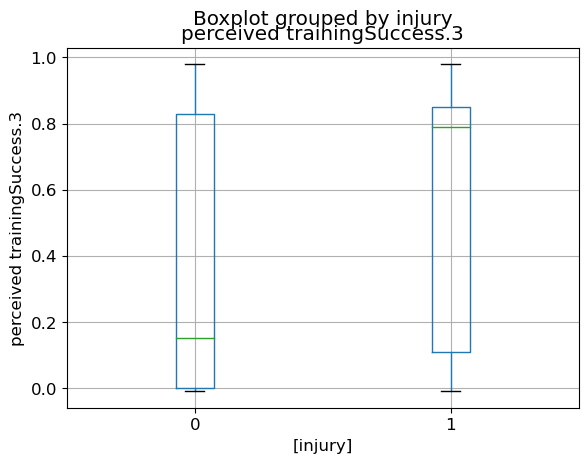

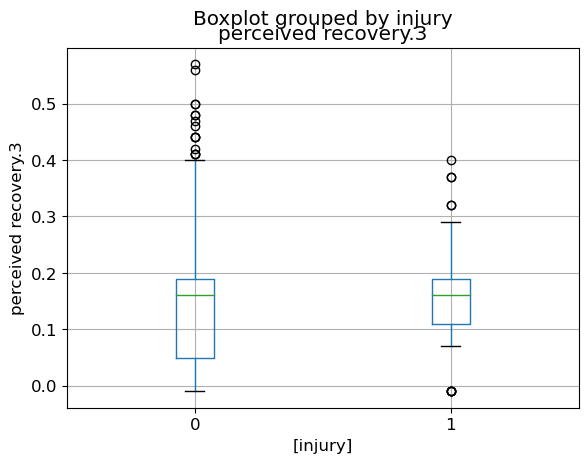

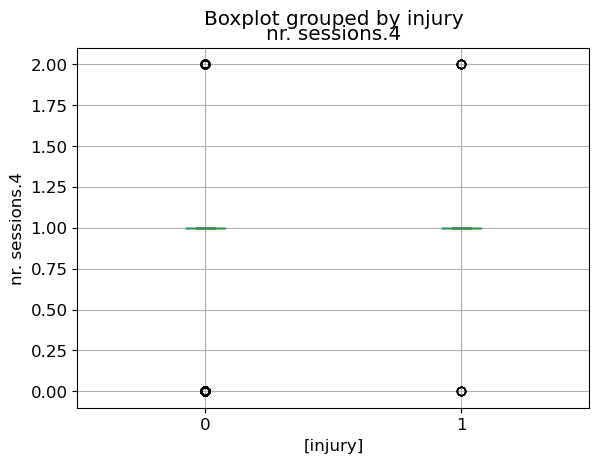

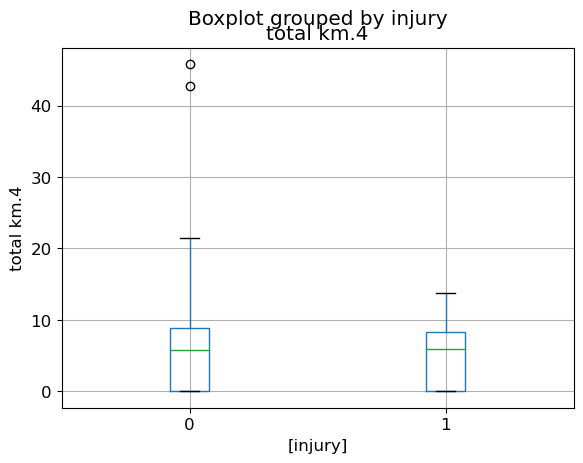

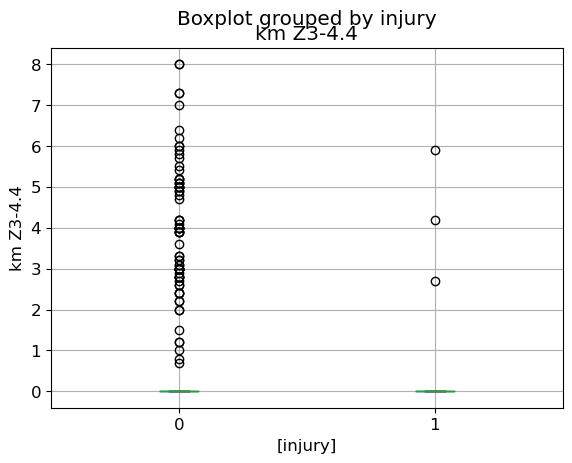

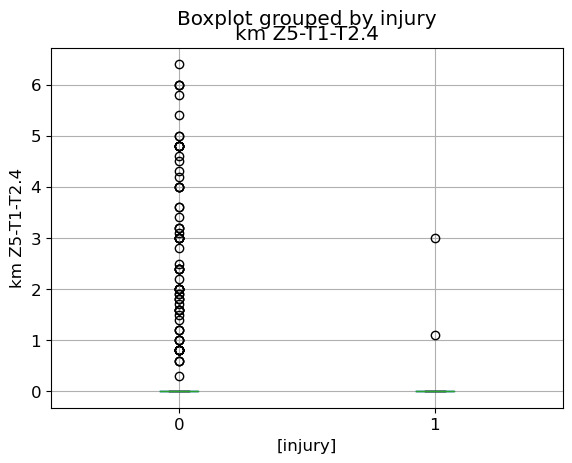

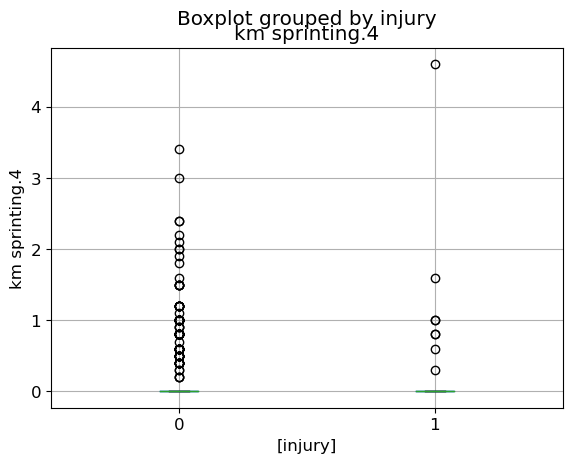

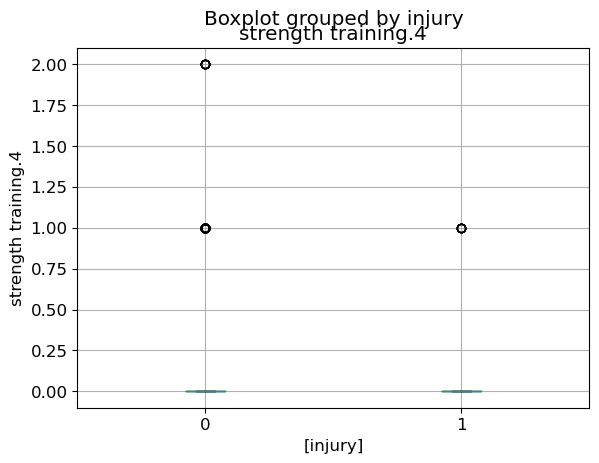

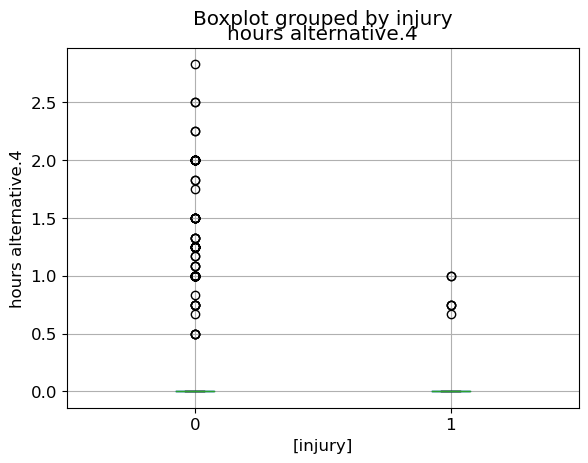

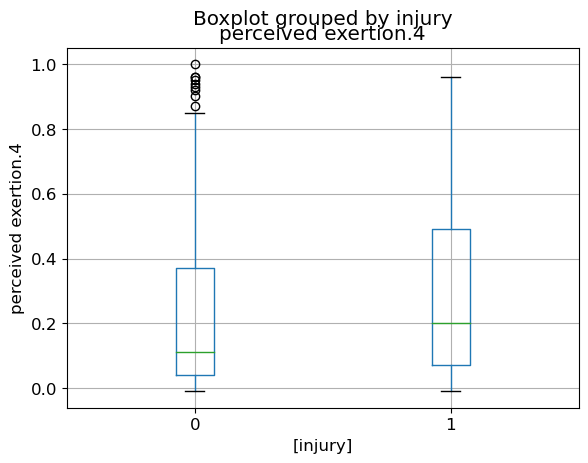

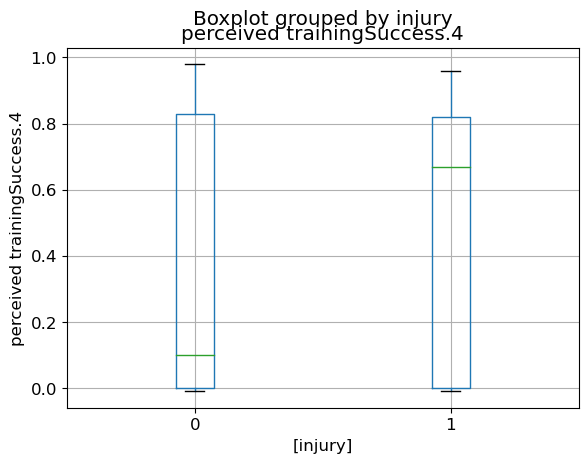

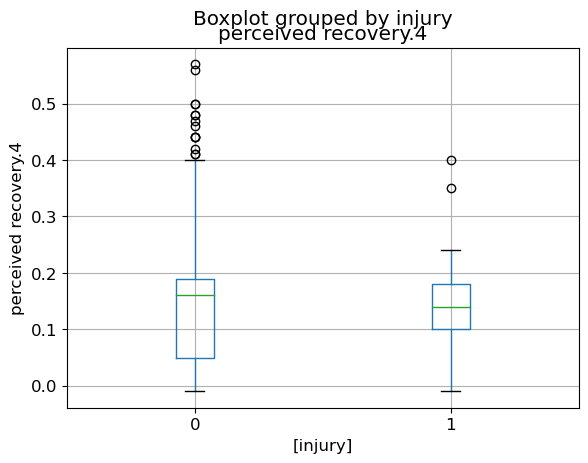

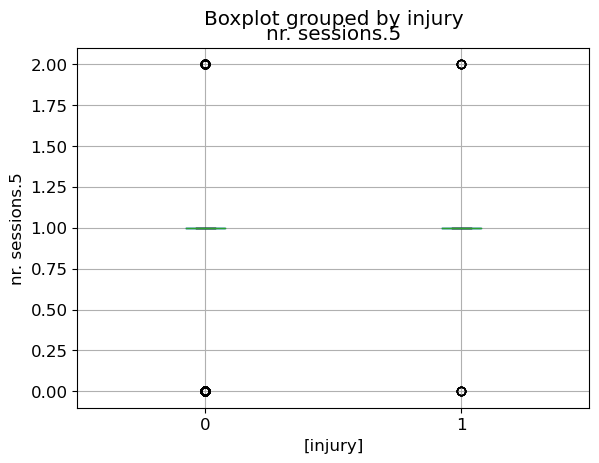

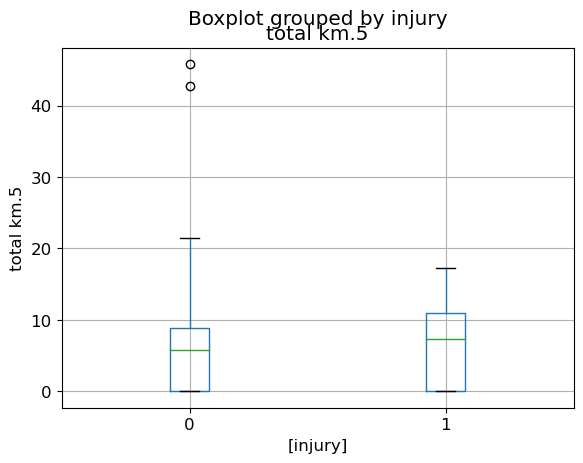

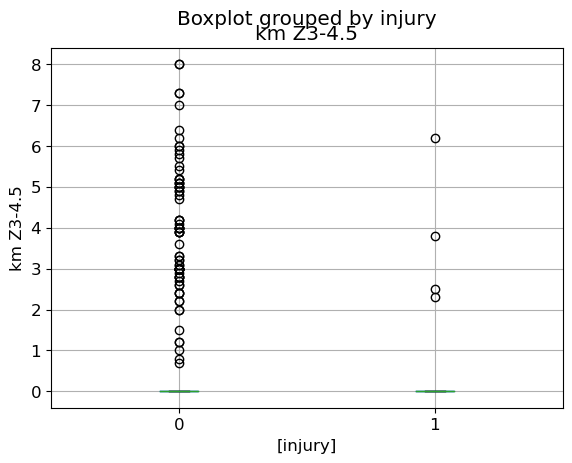

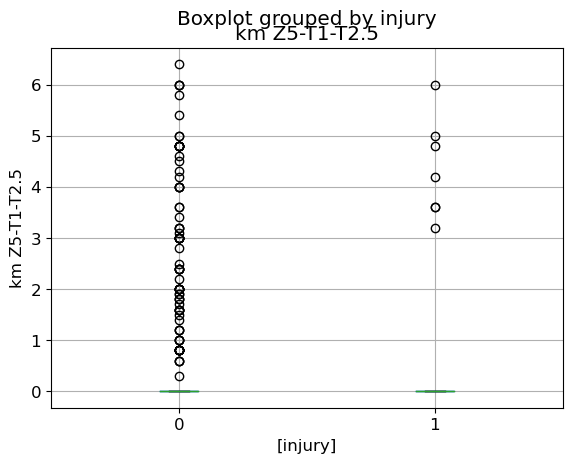

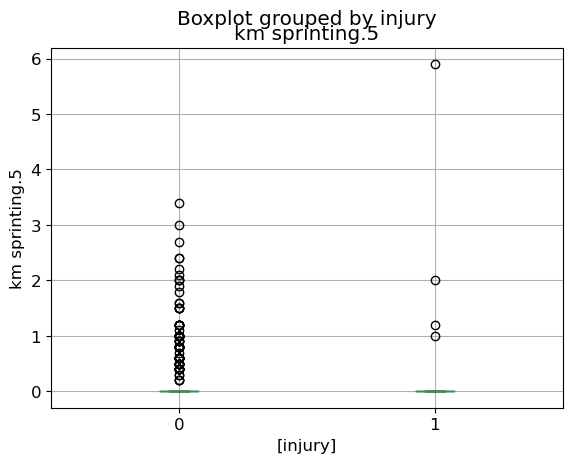

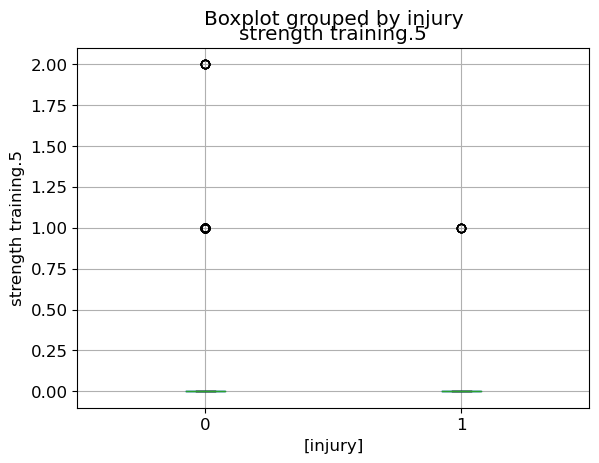

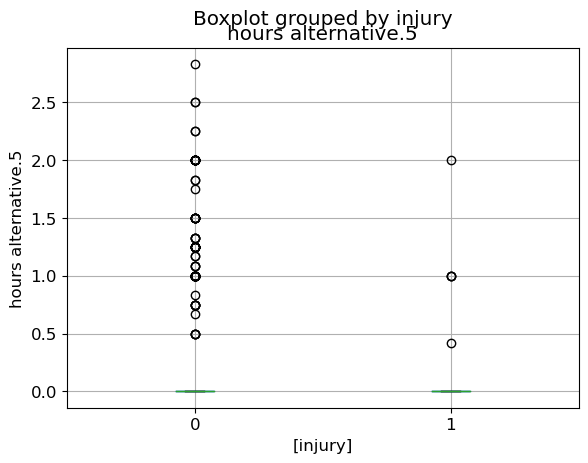

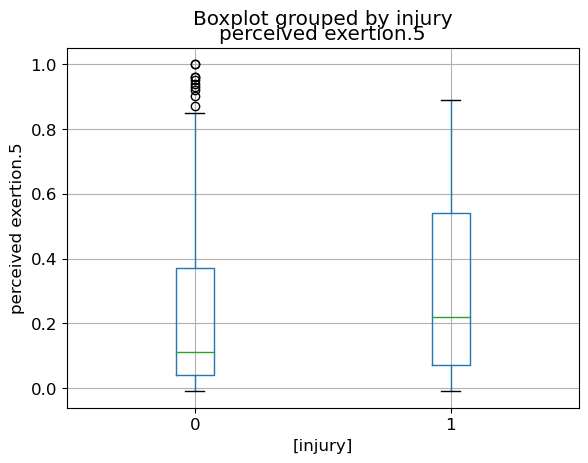

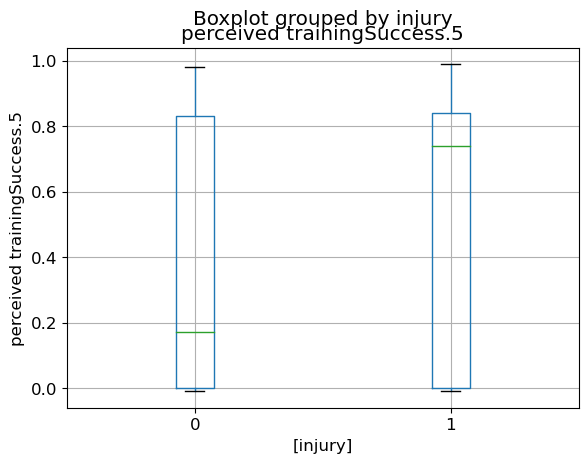

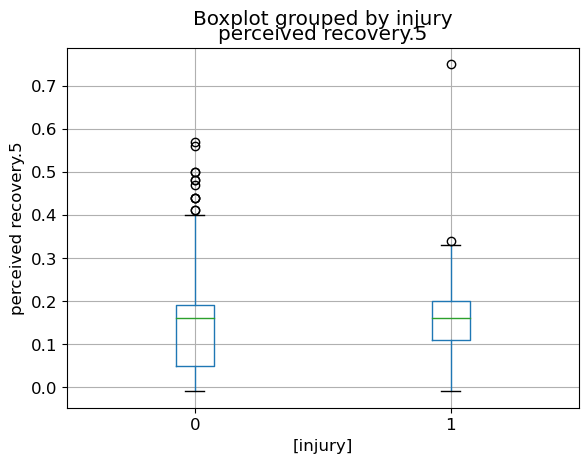

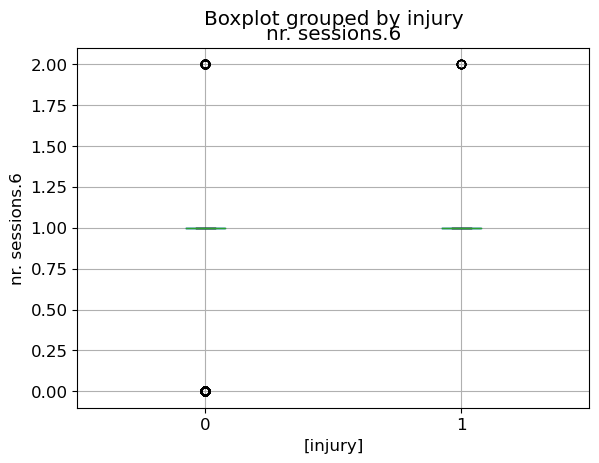

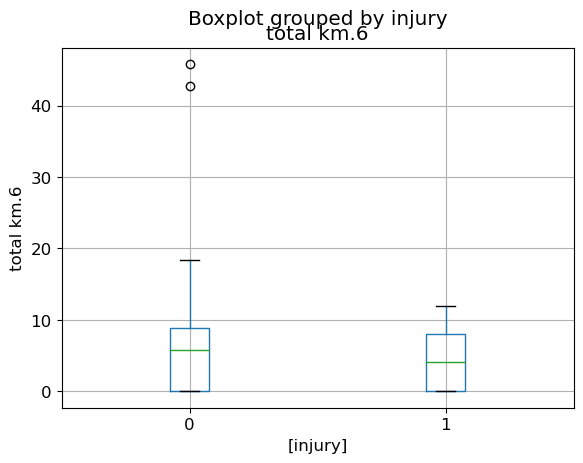

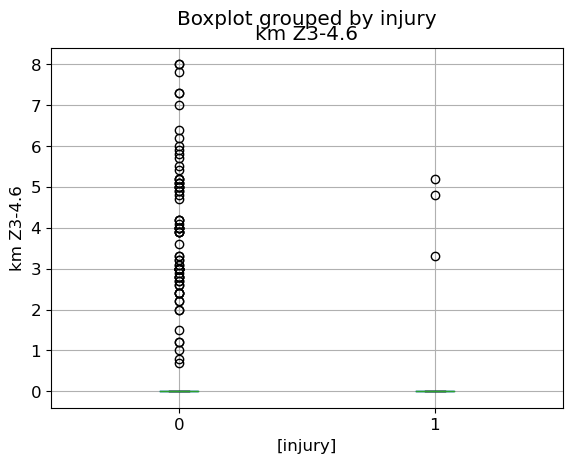

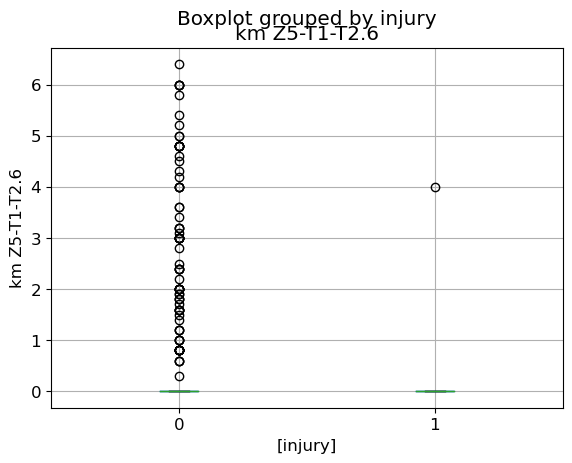

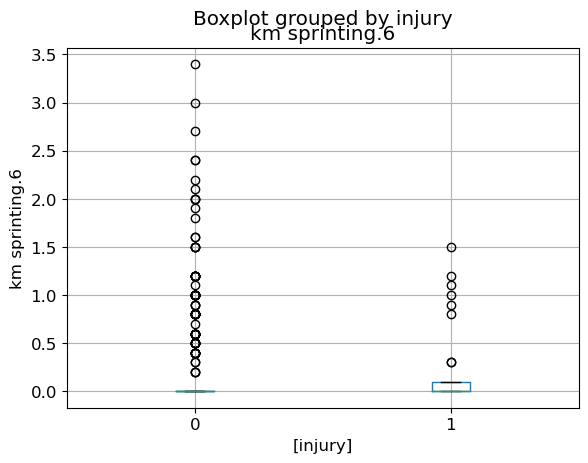

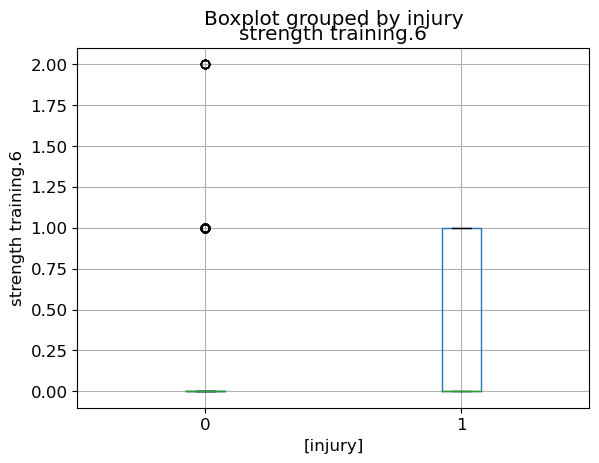

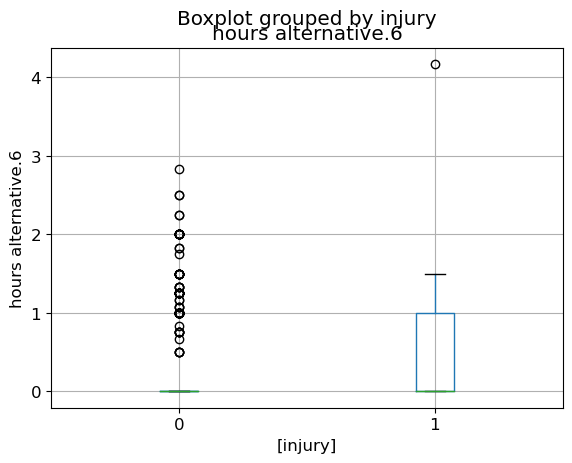

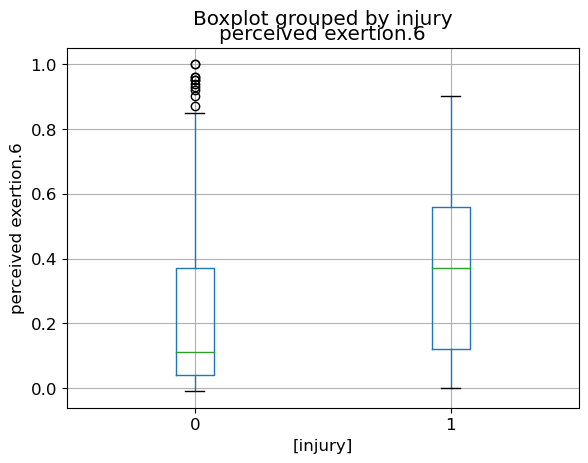

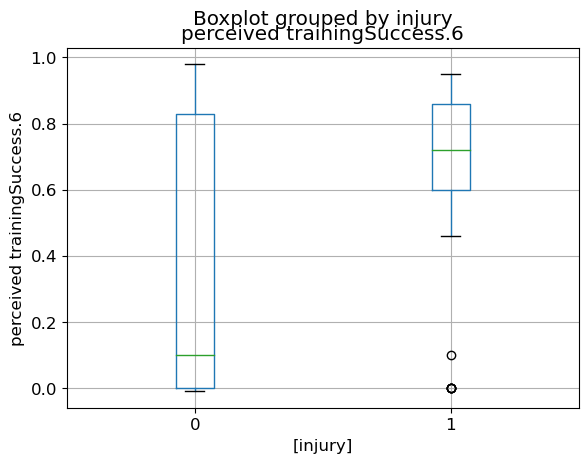

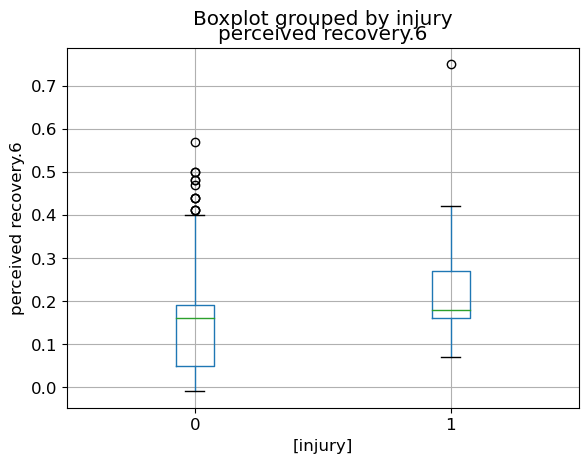

In [19]:
for ftr in cont_ftrs:
    df_29[[ftr,'injury']].boxplot(by = 'injury')
    plt.ylabel(ftr)
    plt.savefig('../figures/{}-injury.png'.format(ftr))
    plt.show()

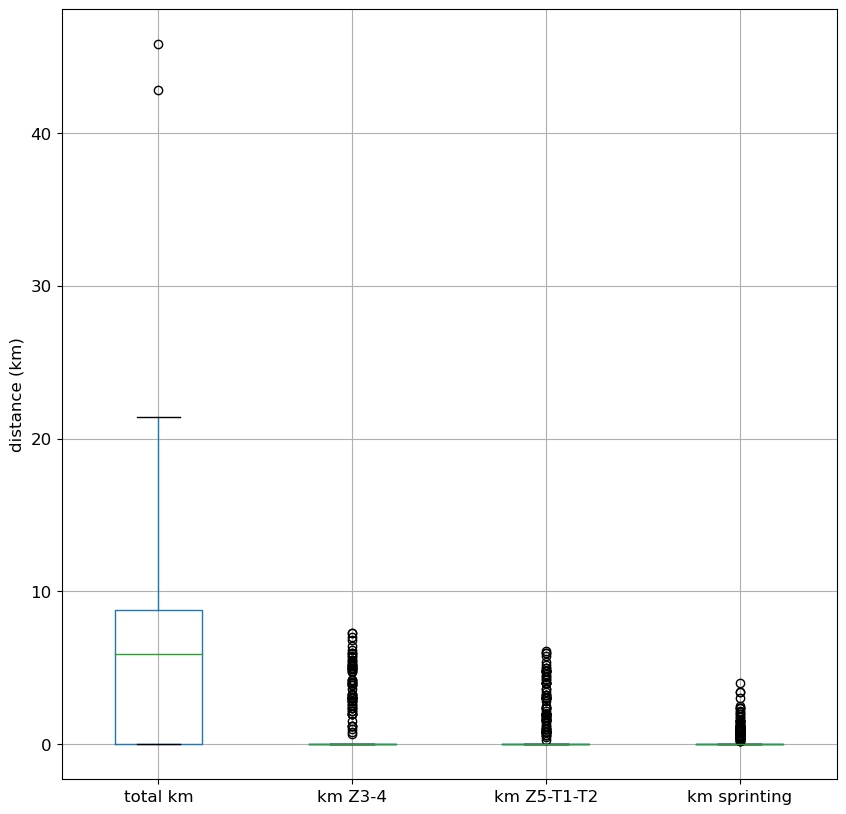

In [20]:
df_29.boxplot(column=['total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting'], figsize = (10,10) )
plt.ylabel('distance (km)')
plt.show()

Correlation Matrix

### Adding average, min and max features ###


In [5]:
df = df.replace(-1,0)

In [6]:
columns = df.columns
columns

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

In [118]:
col_names = ['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery']
minmax_names = ['total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting','hours alternative']
for col_name in col_names:
    df_29['ave {}'.format(col_name)] = df_29[[col for col in columns if col.startswith(col_name)]].mean(axis=1)

for col_name in minmax_names:   
    df_29['max {}'.format(col_name)] = df_29[[col for col in columns if col.startswith(col_name)]].max(axis=1)



In [106]:
df_29.columns

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

### Splitting Data ###

only considering the time series structure for now

still need to do more work to figure out how to deal with the issue that data from different athletes is not iid


In [107]:
df_29['Date'].nunique()

730

In [119]:
df_29 = df_29.sort_values(by = 'Date')
X = df_29[[col for col in df_29.columns if col.startswith('ave') or col in col_names or col.startswith('max')]]
y = df_29['injury']
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,shuffle=False)


In [120]:
np.sum(y_train)

14

In [121]:
X.columns

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'ave nr. sessions',
       'ave total km', 'ave km Z3-4', 'ave km Z5-T1-T2', 'ave km sprinting',
       'ave strength training', 'ave hours alternative',
       'ave perceived exertion', 'ave perceived trainingSuccess',
       'ave perceived recovery', 'max total km', 'max km Z3-4',
       'max km Z5-T1-T2', 'max km sprinting', 'max hours alternative'],
      dtype='object')

### Preprocessing Data ###

all features except athlete ID are continuous
- experimented with minmax scaler and standard scaler
- decided to use standar scaler because although these features have a clear lower bound, they do not have a clear upper bound and have many outliers, does not make sense to contain everything between 0 and 1


athlete ID is categorical so I used onehotencoder to transform it



### Build a pipeline to transform data and train models

In [122]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, make_scorer
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [123]:
# make lists for different features to transform


other_ftrs = ['injury', 'Date']

# will leave this feature as is because it is already between 0 and 1
# perc_ftrs = [col for col in df if col.startswith('perceiv')]

# use standard scaler for other continuous variables
std_ftrs = [col for col in X if (col not in other_ftrs)]


#### Prepare column transformer ####

In [124]:
preprocessor = ColumnTransformer(
    transformers=[('std', StandardScaler(), std_ftrs)])

In [125]:
prep = Pipeline(steps=[('preprocessor', preprocessor)])

In [126]:
X_train_prep = prep.fit_transform(X_train)
X_val_prep = prep.transform(X_val)
X_test_prep = prep.transform(X_test)

In [127]:
X_train_prep = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
X_val_prep = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())
X_test_prep = pd.DataFrame(X_test_prep, columns = preprocessor.get_feature_names_out())
X_train_prep.head()

std__nr. sessions  std__total km  std__km Z3-4  std__km Z5-T1-T2  \
0           0.306988       0.743965     -0.324380         -0.332766   
1           0.306988       0.627952      1.331544          1.852412   
2           0.306988       0.581547     -0.324380         -0.332766   
3           0.306988       0.883180      0.669175          0.759823   
4          -1.699887      -1.367467     -0.324380         -0.332766   

   std__km sprinting  std__strength training  std__hours alternative  \
0          -0.378872               -0.246714               -0.198354   
1          -0.378872               -0.246714               -0.198354   
2          -0.378872               -0.246714               -0.198354   
3          -0.378872               -0.246714               -0.198354   
4          -0.378872               -0.246714               -0.198354   

   std__perceived exertion  std__perceived trainingSuccess  \
0                -0.310969                       -0.646714   
1                -0.216119                       -0.646714   
2                -0.310969                       -0.646714   
3                -0.168694                       -0.646714   
4                -0.785219                       -0.671732   

   std__perceived recovery  ...  std__ave strength training  \
0                 0.537346  ...                   -0.575436   
1                 0.537346  ...                   -0.575436   
2                 0.432088  ...                   -0.575436   
3                 0.642604  ...                   -0.575436   
4                -1.462561  ...                   -0.575436   

   std__ave hours alternative  std__ave perceived exertion  \
0                   -0.484826                    -0.512767   
1                   -0.484826                    -0.501438   
2                   -0.484826                    -0.524097   
3                   -0.484826                    -0.490109   
4                   -0.484826                    -0.637390   

   std__ave perceived trainingSuccess  std__ave perceived recovery  \
0                           -0.753164                     0.475061   
1                           -0.753164                     0.506417   
2                           -0.753164                     0.506417   
3                           -0.753164                     0.537772   
4                           -0.757356                    -0.089342   

   std__max total km  std__max km Z3-4  std__max km Z5-T1-T2  \
0           0.287083         -0.008289              0.531953   
1           0.287083         -0.008289              0.531953   
2           0.287083         -0.375953              0.531953   
3           0.287083         -0.375953              0.531953   
4           0.287083         -0.927449              0.531953   

   std__max km sprinting  std__max hours alternative  
0              -0.456654                   -0.518518  
1              -0.456654                   -0.518518  
2              -0.456654                   -0.518518  
3              -0.456654                   -0.518518  
4              -0.456654                   -0.518518  

[5 rows x 25 columns]

In [128]:
corr_matrix = X_train_prep.corr()

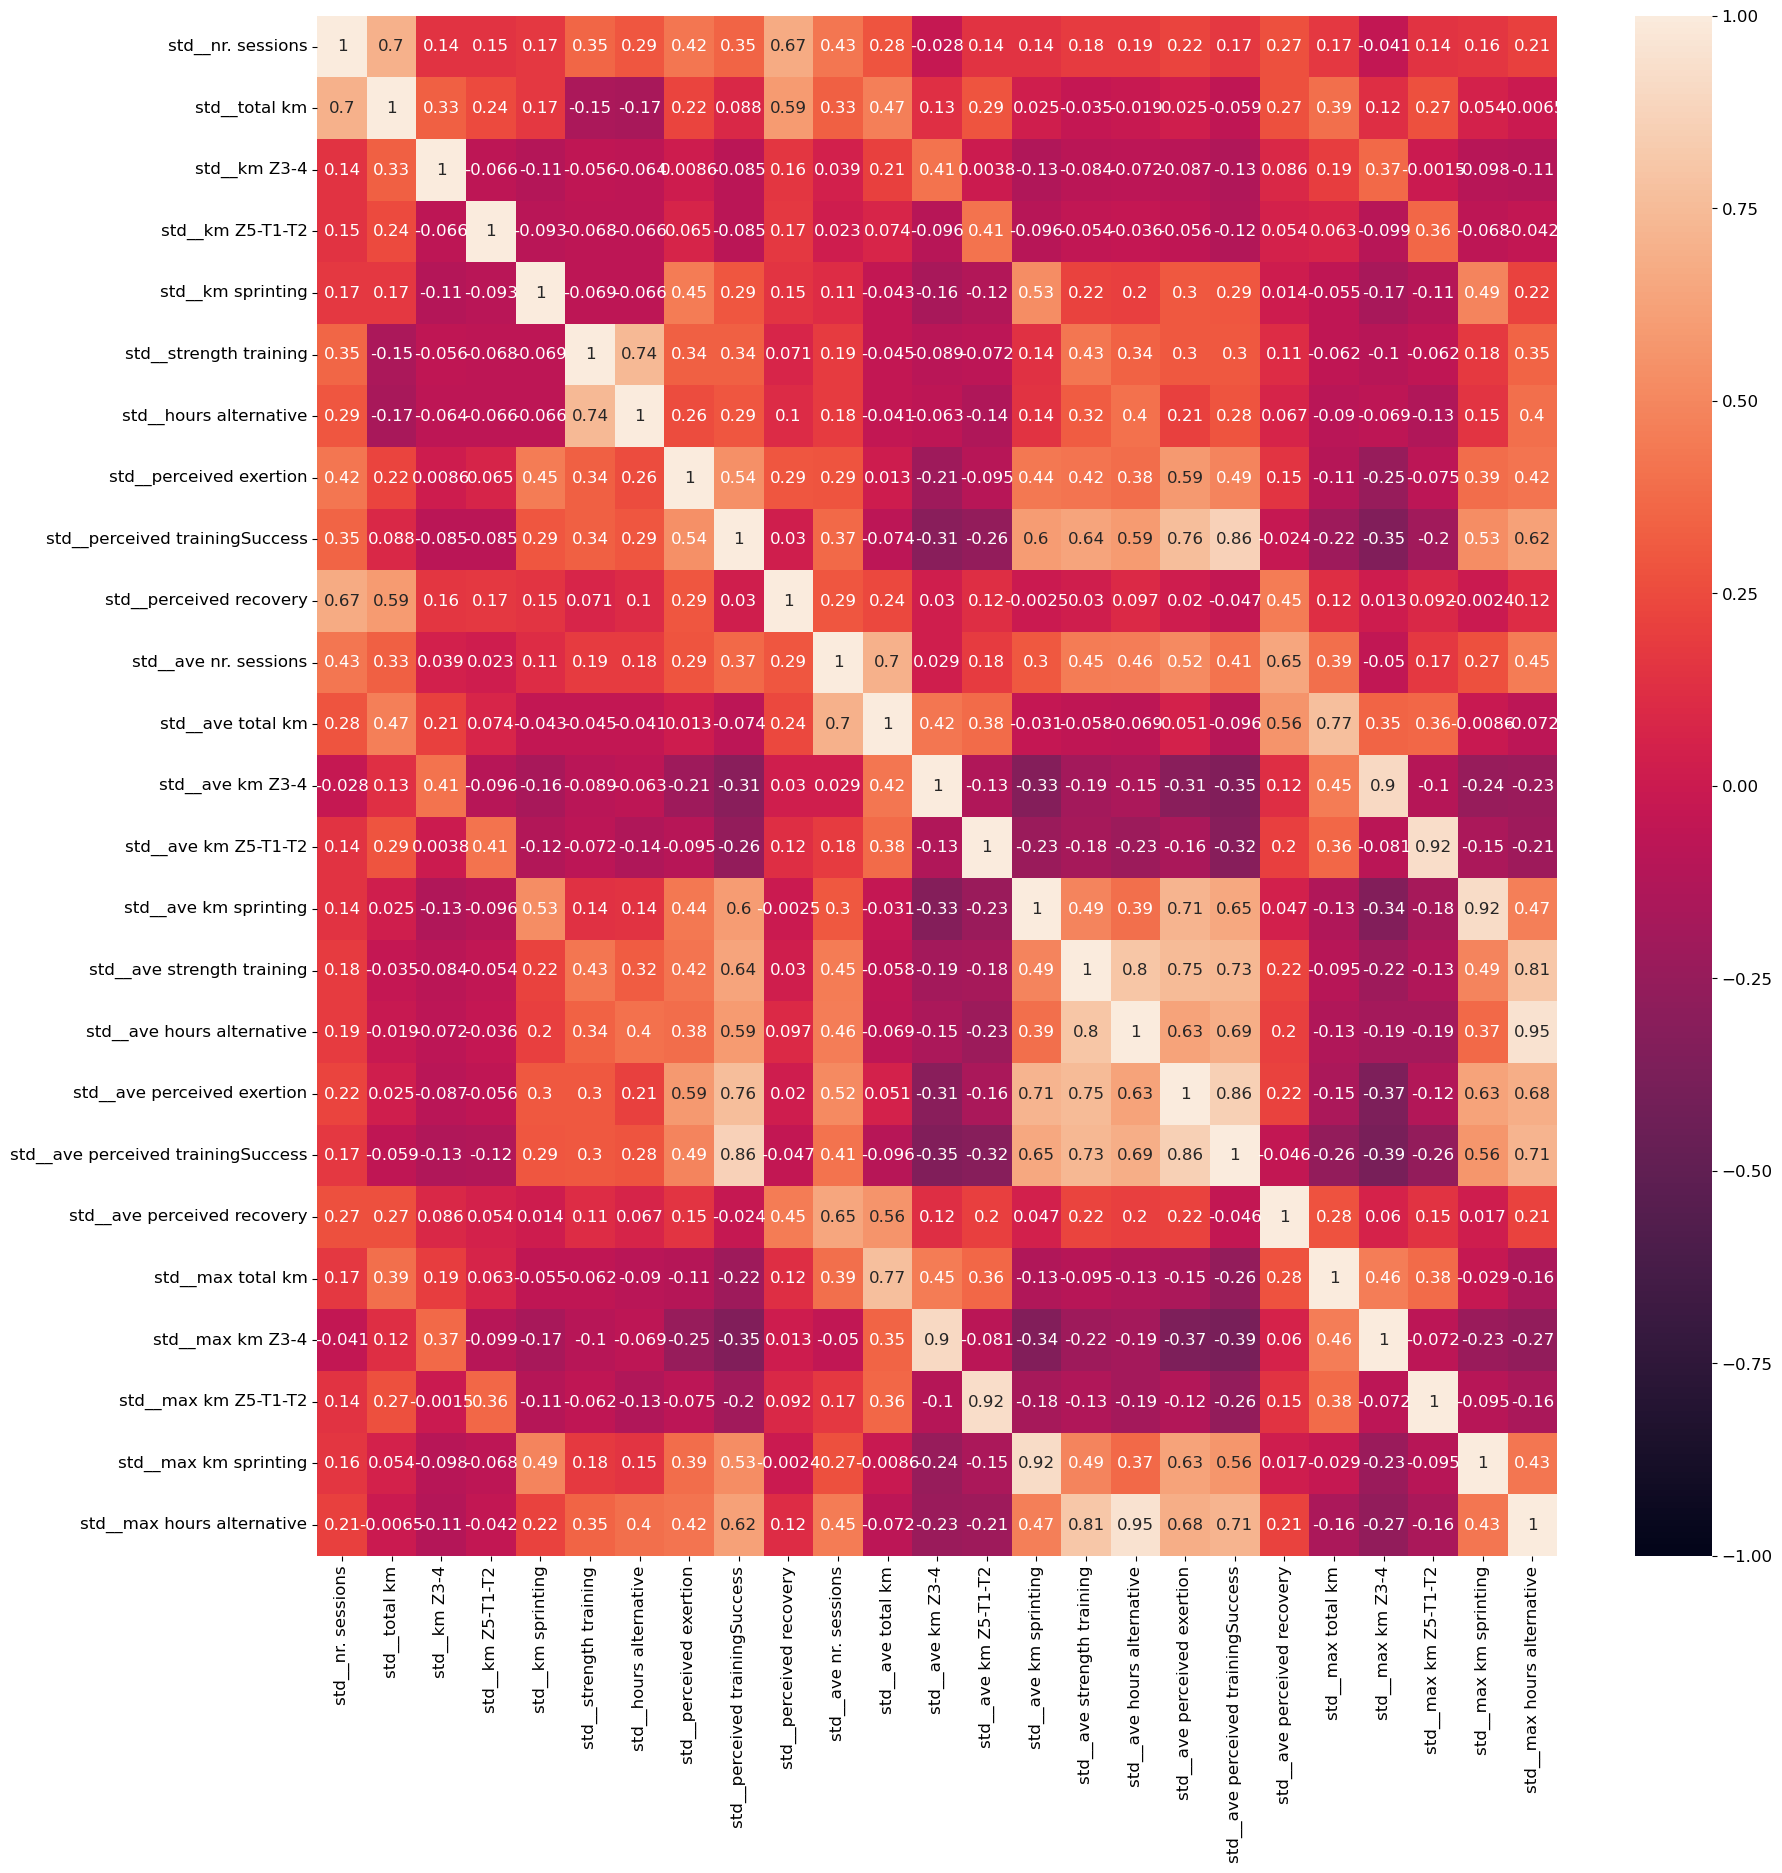

In [129]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,vmin=-1,vmax=1,annot=True)
plt.show()

Logistic Regression:

In [133]:
# train a logistic regression model:



param_grid = {'C': [0.0001,0.001,0.1,1]
              }


train_score = np.zeros(len(ParameterGrid(param_grid)))
f2_score = np.zeros(len(ParameterGrid(param_grid)))
recall = np.zeros(len(ParameterGrid(param_grid)))
models = []

# loop through all combinations of hyperparameter combos
for p in range(len(ParameterGrid(param_grid))):
    params = ParameterGrid(param_grid)[p]
    print('   ',params) 
    logreg = LogisticRegression(**params,max_iter=1000,class_weight='balanced') # initialize the classifier
    logreg.fit(X_train_prep,y_train) # fit the model
    models.append(logreg) # save it
    # calculate train and validation accuracy scores
    y_train_pred = logreg.predict(X_train_prep)
    train_score[p] = fbeta_score(y_train,y_train_pred,beta=2)
    y_val_pred = logreg.predict(X_val_prep)
    f2_score[p] = fbeta_score(y_val,y_val_pred,beta=2)
    recall[p] = recall_score(y_val,y_val_pred)
    print('   ',train_score[p],f2_score[p],recall[p])


    {'C': 0.0001}
    0.2424242424242424 0.38793103448275856 0.9
    {'C': 0.001}
    0.24390243902439024 0.41666666666666663 0.9
    {'C': 0.1}
    0.4744525547445256 0.3883495145631068 0.8
    {'C': 1}
    0.5691056910569106 0.37383177570093457 0.8


In [141]:
# build the pipeline


def MLpipe(X_train, y_train, X_val, y_val, X_test, y_test, algo, param_grid):
    nr_states = 5
    
    final_models = []
    final_test_scores = []
    for i in range(nr_states):
        models = []
        val_scores = []
        train_scores = []
        
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            
            # intialize algorithm:
            clf = algo(**params, random_state = i*42, class_weight='balanced')
            clf.fit(X_train,y_train)
            y_val_pred = clf.predict(X_val)
            #val_scores.append(recall_score(y_val, y_val_pred))
            #train_scores.append(recall_score(y_train, y_train_pred))
            val_scores.append(fbeta_score(y_val, y_val_pred, beta=2))
            train_scores.append(fbeta_score(y_train, clf.predict(X_train), beta=2))
            models.append(clf)
        best_model = models[np.argmax(val_scores)]
        final_models.append(best_model)
        #final_test_scores.append(recall_score(y_test, best_model.predict(X_test)))
        final_test_scores.append(fbeta_score(y_test, best_model.predict(X_test), beta=2))
        print('prediction:', y_val_pred)
        print('train scores:', train_scores)
    return final_models, final_test_scores
            

In [135]:
def deMLpipe(X_train, y_train, X_val, y_val, X_test, y_test, algo, param_grid):
    nr_states = 5
    
    val_scores = []
    models = []
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]

        # intialize algorithm:
        clf = algo(**params)
        clf.fit(X_train,y_train)
        y_val_pred = clf.predict(X_val)
        val_scores.append(fbeta_score(y_val, y_val_pred, beta=2))
        models.append(clf)
    
    best_model = models[np.argmax(val_scores)]
    final_test_score = (fbeta_score(y_test, best_model.predict(X_test), beta=2))
    print('prediction:', y_val_pred)
    
    return best_model, final_test_score

In [139]:
rf_grid = {'max_depth': [1, 3, 10, 30, 100],
              'max_features': [0.5,0.75,1.0],
              'max_depth':[5,10,15,20,50],
            'max_samples':[0.25,0.5,0.75,1.0]
              }

final_models, final_test_scores = MLpipe(X_train_prep, y_train, X_val_prep, y_val, X_test_prep, y_test, RandomForestClassifier, rf_grid)

prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [140]:
final_test_scores

[0.0, 0.0, 0.0, 0.0, 0.0]

So bad !

In [142]:
svc_grid = {'gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
              'C': [1e-1, 1e0, 1e1] 
              }
final_models, final_test_scores = MLpipe(X_train_prep, y_train, X_val_prep, y_val, X_test_prep, y_test, SVC, svc_grid)

prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train scores: [0.28409090909090906, 0.7070707070707072, 1.0, 1.0, 1.0, 0.2777777777777778, 0.9722222222222222, 1.0, 1.0, 1.0, 0.3846153846153846, 1.0, 1.0, 1.0, 1.0]
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train scores: [0.28409090909090906, 0.7070707070707072, 1.0, 1.0, 1.0, 0.2777777777777778, 0.9722222222222222, 1.0, 1.0, 1.0, 0.3846153846153846, 1.0, 1.0, 1.0, 1.0]
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [143]:
final_test_scores

[0.2597402597402597,
 0.2597402597402597,
 0.2597402597402597,
 0.2597402597402597,
 0.2597402597402597]

In [144]:
knn_grid = {'n_neighbors': [1,10,50,100,150,200],
              'weights': ['uniform','distance']
              }
final_model, final_test_score = deMLpipe(X_train_prep, y_train, X_val_prep, y_val, X_test_prep, y_test, KNeighborsClassifier, knn_grid)

prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

In [145]:
final_test_score

0.08928571428571427

### Reflection and thoughts for next steps:

what my models are doing right now:
- all of the models are predicting 0 for all datapoints, except for logistic regression which predicts 1 for one of the datapoints
- there is definitely overfitting because the train scores are very high
- changing the random state doesn't really do anything? is it because my dataset is too small?

what to do next:
- dealing with multicolinearity
- feature engineering:

### Repeat above for all datapoints in the dataframe 
will results improve?
can I calculate the score for athlete 29 and see if it is higher when we also use information from other athletes?